# Загрузка библиотек

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install catboost
!pip install category_encoders

In [3]:
!pip install optuna

In [4]:
!pip install eli5

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict, RandomizedSearchCV
from catboost import CatBoostClassifier, cv, Pool
from sklearn.metrics import mean_absolute_error, roc_curve,accuracy_score, roc_auc_score, confusion_matrix, f1_score, log_loss

from sklearn.feature_selection import RFE
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold
import category_encoders as ce

import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import datetime
from sklearn.feature_selection import RFECV


import eli5
from eli5.sklearn import PermutationImportance


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
pd.set_option('display.max_rows',2000)
pd.set_option('display.max_columns',2000)

In [7]:
PATH = '/content/drive/My Drive/mkb'

In [8]:
# загрузка данных
data_train = pd.read_csv(PATH+'/train_dataset_hackathon_mkb.csv', encoding='cp1251', sep=';')
data_test = pd.read_csv(PATH+'/test_dataset_hackathon_mkb.csv', encoding='cp1251', sep=';')

data_train.shape, data_test.shape

((17891, 124), (7330, 123))

# Аномалии

In [9]:
%%time

# в датасете встречаются клиенты, у которых со временем меняются метки ИП. Предположим, что это ошибка, назначим одну метку, заполним пропуски 


#1 - 9988
data_train.loc[(data_train['id_client']==9988), 'F1100':'OKVED_CODE'] = data_test.loc[(data_test['id_client']==9988), 'F1100':'OKVED_CODE'].iloc[0].to_list()
data_train.loc[(data_train['id_client']==9988), 'IP_flag'] = data_test.loc[(data_test['id_client']==9988), 'IP_flag'].iloc[0]

#2 - 10092 
data_train.loc[data_train['id_client']==10092, 'IP_flag'] = 0
data_test.loc[data_test['id_client']==10092, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==10092), 'F1100':] = data_train.loc[(data_train['id_client']==10092), 'F1100':].fillna(method = 'ffill')
data_train.loc[(data_train['id_client']==10092), 'F1100':] = data_train.loc[(data_train['id_client']==10092), 'F1100':].fillna(method = 'bfill')
data_test.loc[(data_test['id_client']==10092), 'F1100':] = data_train.loc[(data_train['id_client']==10092), 'F1100':].iloc[0].to_list()

#3 - 1132
data_train.loc[data_train['id_client']==1132, 'IP_flag'] = 0
data_test.loc[(data_test['id_client']==1132), 'F1100':'F2400_LAG1'] = data_test.loc[(data_test['id_client']==1132), 'F1100':'F2400_LAG1'].iloc[0].to_list()
data_test.loc[(data_test['id_client']==1132), 'TAXREGPAY_REGDATE':'COUNTBRANCHEGRUL'] = data_test.loc[(data_test['id_client']==1132), 'TAXREGPAY_REGDATE':'COUNTBRANCHEGRUL'].iloc[0].to_list()
data_test.loc[(data_test['id_client']==1132), 'COUNT_CHANGE_EVER'] = 2
data_train.loc[(data_train['id_client']==1132), 'COUNT_CHANGE_EVER'] = 2
data_train.loc[(data_train['id_client']==1132), 'F1100':] = data_train.loc[(data_train['id_client']==1132), 'F1100':].fillna(method = 'bfill')

#4 - 822
data_train.loc[data_train['id_client']==822, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==822), 'F1100':] = data_train.loc[(data_train['id_client']==822), 'F1100':].fillna(method = 'bfill')

#5 - 11209
data_train.loc[data_train['id_client']==11209, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==11209), 'F1100':] = data_train.loc[(data_train['id_client']==11209), 'F1100':].fillna(method = 'ffill')
data_train.loc[(data_train['id_client']==11209), 'F1100':] = data_train.loc[(data_train['id_client']==11209), 'F1100':].fillna(method = 'bfill')

#6 - 9600
data_train.loc[data_train['id_client']==9600, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==9600), 'F1100':] = data_train.loc[(data_train['id_client']==9600), 'F1100':].fillna(method = 'bfill')

#7 - 11514
data_train.loc[data_train['id_client']==11514, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==11514), 'F1100':] = data_train.loc[(data_train['id_client']==11514), 'F1100':].fillna(method = 'bfill')

#8 - 1006
data_train.loc[data_train['id_client']==1006, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==1006), 'F1100':] = data_train.loc[(data_train['id_client']==1006), 'F1100':].fillna(method = 'bfill')

#9 - 4119
data_train.loc[data_train['id_client']==4119, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==4119), 'F1100':] = data_train.loc[(data_train['id_client']==4119), 'F1100':].fillna(method = 'bfill')
data_train.loc[(data_train['id_client']==4119), 'F1100':] = data_train.loc[(data_train['id_client']==4119), 'F1100':].fillna(method = 'ffill')

#10 - 6466
data_test.loc[data_test['id_client']==6466, 'IP_flag'] = 0
data_train.loc[data_train['id_client']==6466, 'IP_flag'] = 0
data_test.loc[(data_test['id_client']==6466), 'F1100':] = data_test.loc[(data_test['id_client']==6466), 'F1100':].fillna(method = 'bfill')
data_train.loc[(data_train['id_client']==6466), 'F1100':] = data_test.loc[(data_test['id_client']==6466), 'F1100':].iloc[0].to_list()

#11 - 8034
data_train.loc[data_train['id_client']==8034, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==8034), 'F1100':] = data_train.loc[(data_train['id_client']==8034), 'F1100':].fillna(method = 'bfill')

#12 - 11257
data_train.loc[data_train['id_client']==11257, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==11257), 'F1100':] = data_train.loc[(data_train['id_client']==11257), 'F1100':].fillna(method = 'bfill')
data_test.loc[(data_test['id_client']==11257), 'F1100':] = data_test.loc[(data_test['id_client']==11257), 'F1100':].fillna(method = 'bfill')

#13 - 10196 
data_train.loc[data_train['id_client']==10196, 'IP_flag'] = 0
data_test.loc[data_test['id_client']==10196, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==10196), 'F1100':] = data_train.loc[(data_train['id_client']==10196), 'F1100':].fillna(method = 'bfill')
data_train.loc[(data_train['id_client']==10196), 'F1100':] = data_train.loc[(data_train['id_client']==10196), 'F1100':].fillna(method = 'ffill')
data_test.loc[(data_test['id_client']==10196), 'F1100':] = data_train.loc[(data_train['id_client']==10196), 'F1100':].iloc[-1].to_list()

#14 - 1249
data_train.loc[data_train['id_client']==1249, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==1249), 'F1100':] = data_train.loc[(data_train['id_client']==1249), 'F1100':].fillna(method = 'bfill')

#15 - 3479
data_train.loc[data_train['id_client']==3479, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==3479), 'F1100':] = data_train.loc[(data_train['id_client']==3479), 'F1100':].fillna(method = 'bfill')
data_train.loc[(data_train['id_client']==3479), 'F1100':] = data_train.loc[(data_train['id_client']==3479), 'F1100':].fillna(method = 'ffill')

#16 - 8801
data_train.loc[data_train['id_client']==8801, 'IP_flag'] = 0
data_test.loc[data_test['id_client']==8801, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==8801), 'F1100':] = data_train.loc[(data_train['id_client']==8801), 'F1100':].fillna(method = 'bfill')
data_test.loc[(data_test['id_client']==8801), 'F1100':] = data_test.loc[(data_test['id_client']==8801), 'F1100':].fillna(method = 'bfill')

#17 - 10845
data_train.loc[data_train['id_client']==10845, 'IP_flag'] = 0
data_test.loc[data_test['id_client']==10845, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==10845), 'F1100':] = data_train.loc[(data_train['id_client']==10845), 'F1100':].fillna(method = 'bfill')
data_test.loc[(data_test['id_client']==10845), 'F1100':] = data_test.loc[(data_test['id_client']==10845), 'F1100':].fillna(method = 'bfill')
data_test.loc[(data_test['id_client']==10845), 'F1100':] = data_test.loc[(data_test['id_client']==10845), 'F1100':].fillna(method = 'ffill')

#18 - 11223
data_train.loc[data_train['id_client']==11223, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==11223), 'F1100':] = data_train.loc[(data_train['id_client']==11223), 'F1100':].fillna(method = 'bfill')
data_train.loc[(data_train['id_client']==11223), 'F1100':] = data_train.loc[(data_train['id_client']==11223), 'F1100':].fillna(method = 'ffill')

#19 - 7620
data_train.loc[data_train['id_client']==7620, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==7620), 'F1100':] = data_train.loc[(data_train['id_client']==7620), 'F1100':].fillna(method = 'bfill')

#20 - 2790
data_train.loc[data_train['id_client']==2790, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==2790), 'F1100':] = data_train.loc[(data_train['id_client']==2790), 'F1100':].fillna(method = 'bfill')

#21 - 3916
data_train.loc[data_train['id_client']==3916, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==3916), 'F1100':] = data_train.loc[(data_train['id_client']==3916), 'F1100':].fillna(method = 'ffill')

#22 - 11922
data_train.loc[data_train['id_client']==11922, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==11922), 'F1100':] = data_train.loc[(data_train['id_client']==11922), 'F1100':].fillna(method = 'bfill')

#23 - 11192
data_train.loc[data_train['id_client']==11192, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==11192), 'F1100':] = data_train.loc[(data_train['id_client']==11192), 'F1100':].fillna(method = 'ffill')

#24 - 10044
data_train.loc[data_train['id_client']==10044, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==10044), 'F1100':] = data_train.loc[(data_train['id_client']==10044), 'F1100':].fillna(method = 'ffill')

#25 - 1847
data_train.loc[data_train['id_client']==1847, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==1847), 'F1100':] = data_train.loc[(data_train['id_client']==1847), 'F1100':].fillna(method = 'ffill')

#26 - 11374
data_train.loc[data_train['id_client']==11374, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==11374), 'F1100':] = data_train.loc[(data_train['id_client']==11374), 'F1100':].fillna(method = 'ffill')

#27 - 1535
data_train.loc[data_train['id_client']==1535, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==1535), 'F1100':] = data_train.loc[(data_train['id_client']==1535), 'F1100':].fillna(method = 'ffill')

#28 - 2951
data_train.loc[data_train['id_client']==2951, 'IP_flag'] = 0
data_test.loc[data_test['id_client']==2951, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==2951), 'F1100':] = data_train.loc[(data_train['id_client']==2951), 'F1100':].fillna(method = 'ffill')
data_test.loc[(data_test['id_client']==2951), 'F1100':] = data_test.loc[(data_test['id_client']==2951), 'F1100':].fillna(method = 'ffill')

#29 - 3629 ??? хз может и ИП
data_train.loc[data_train['id_client']==3629, 'IP_flag'] = 0
data_test.loc[data_test['id_client']==3629, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==3629), 'F1100':] = data_train.loc[(data_train['id_client']==3629), 'F1100':].fillna(method = 'ffill')
data_test.loc[(data_test['id_client']==3629), 'F1100':] = data_train.loc[(data_train['id_client']==3629), 'F1100':].iloc[-1].to_list()

#30 - 7775
data_train.loc[data_train['id_client']==7775, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==7775), 'F1100':] = data_train.loc[(data_train['id_client']==7775), 'F1100':].fillna(method = 'ffill')
data_train.loc[(data_train['id_client']==7775), 'F1100':] = data_train.loc[(data_train['id_client']==7775), 'F1100':].fillna(method = 'bfill')

#31 - 233
data_train.loc[data_train['id_client']==233, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==233), 'F1100':] = data_train.loc[(data_train['id_client']==233), 'F1100':].fillna(method = 'bfill')
data_train.loc[(data_train['id_client']==233), 'F1100':] = data_train.loc[(data_train['id_client']==233), 'F1100':].fillna(method = 'ffill')

#32 - 7776
data_train.loc[data_train['id_client']==7776, 'IP_flag'] = 0
data_test.loc[data_test['id_client']==7776, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==7776), 'F1100':] = data_train.loc[(data_train['id_client']==7776), 'F1100':].fillna(method = 'ffill')
data_test.loc[(data_test['id_client']==7776), 'F1100':] = data_test.loc[(data_test['id_client']==7776), 'F1100':].fillna(method = 'ffill')

#33 - 2700 ???? может быть ИП
data_train.loc[data_train['id_client']==2700, 'IP_flag'] = 0
data_test.loc[data_test['id_client']==2700, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==2700), 'F1100':] = data_train.loc[(data_train['id_client']==2700), 'F1100':].fillna(method = 'ffill')
data_test.loc[(data_test['id_client']==2700), 'F1100':] = data_train.loc[(data_train['id_client']==2700), 'F1100':].iloc[-1].to_list()

#34 - 209
data_train.loc[data_train['id_client']==209, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==209), 'F1100':] = data_train.loc[(data_train['id_client']==209), 'F1100':].fillna(method = 'ffill')

#35 - 3586 
data_train.loc[data_train['id_client']==3586, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==3586), 'F1100':] = data_train.loc[(data_train['id_client']==3586), 'F1100':].fillna(method = 'ffill')

#36 - 5822 
data_train.loc[data_train['id_client']==5822, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==5822), 'F1100':] = data_train.loc[(data_train['id_client']==5822), 'F1100':].fillna(method = 'bfill')

#37 - 645
data_train.loc[data_train['id_client']==645, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==645), 'F1100':] = data_train.loc[(data_train['id_client']==645), 'F1100':].fillna(method = 'ffill')

#38 - 834
data_train.loc[data_train['id_client']==834, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==834), 'F1100':] = data_train.loc[(data_train['id_client']==834), 'F1100':].fillna(method = 'bfill')

#39 - 10489
data_train.loc[data_train['id_client']==10489, 'IP_flag'] = 0
data_test.loc[data_test['id_client']==10489, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==10489), 'F1100':] = data_train.loc[(data_train['id_client']==10489), 'F1100':].fillna(method = 'ffill')
data_train.loc[(data_train['id_client']==10489), 'F1100':] = data_train.loc[(data_train['id_client']==10489), 'F1100':].fillna(method = 'bfill')
data_test.loc[(data_test['id_client']==10489), 'F1100':] = data_test.loc[(data_test['id_client']==10489), 'F1100':].fillna(method = 'ffill')

#40 - 11031
data_train.loc[data_train['id_client']==11031, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==11031), 'F1100':] = data_train.loc[(data_train['id_client']==11031), 'F1100':].fillna(method = 'bfill')

#41 - 10342
data_train.loc[data_train['id_client']==10342, 'IP_flag'] = 0
data_test.loc[data_test['id_client']==10342, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==10342), 'F1100':] = data_train.loc[(data_train['id_client']==10342), 'F1100':].fillna(method = 'bfill')
data_test.loc[(data_test['id_client']==10342), 'F1100':] = data_test.loc[(data_test['id_client']==10342), 'F1100':].fillna(method = 'ffill')

#42 - 3703
data_train.loc[data_train['id_client']==3703, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==3703), 'F1100':] = data_train.loc[(data_train['id_client']==3703), 'F1100':].fillna(method = 'ffill')

#43 - 12463
data_train.loc[data_train['id_client']==12463, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==12463), 'F1100':] = data_train.loc[(data_train['id_client']==12463), 'F1100':].fillna(method = 'ffill')

#44 - 1128 
data_train.loc[data_train['id_client']==1128, 'IP_flag'] = 0
data_test.loc[data_test['id_client']==1128, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==1128), 'F1100':] = data_train.loc[(data_train['id_client']==1128), 'F1100':].fillna(method = 'bfill')
data_train.loc[(data_train['id_client']==1128), 'F1100':] = data_train.loc[(data_train['id_client']==1128), 'F1100':].fillna(method = 'ffill')
data_test.loc[(data_test['id_client']==1128), 'F1100':] = data_train.loc[(data_train['id_client']==1128), 'F1100':].iloc[-1].to_list()

#45 - 2785
data_train.loc[data_train['id_client']==2785, 'IP_flag'] = 0
data_test.loc[data_test['id_client']==2785, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==2785), 'F1100':] = data_train.loc[(data_train['id_client']==2785), 'F1100':].fillna(method = 'ffill')
data_train.loc[(data_train['id_client']==2785), 'F1100':] = data_train.loc[(data_train['id_client']==2785), 'F1100':].fillna(method = 'bfill')
data_test.loc[(data_test['id_client']==2785), 'F1100':] = data_train.loc[(data_train['id_client']==2785), 'F1100':].iloc[-1].to_list()

#46 - 1487
data_train.loc[data_train['id_client']==1487, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==1487), 'F1100':] = data_train.loc[(data_train['id_client']==1487), 'F1100':].fillna(method = 'bfill')

#47 - 2789
data_train.loc[data_train['id_client']==2789, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==2789), 'F1100':] = data_train.loc[(data_train['id_client']==2789), 'F1100':].fillna(method = 'ffill')

#48 - 4916
data_train.loc[data_train['id_client']==4916, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==4916), 'F1100':] = data_train.loc[(data_train['id_client']==4916), 'F1100':].fillna(method = 'ffill')

#49 - 857
data_train.loc[data_train['id_client']==857, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==857), 'F1100':] = data_train.loc[(data_train['id_client']==857), 'F1100':].fillna(method = 'bfill')

#50 - 10224
data_train.loc[data_train['id_client']==10224, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==10224), 'F1100':] = data_train.loc[(data_train['id_client']==10224), 'F1100':].fillna(method = 'bfill')

#51 - 168
data_train.loc[data_train['id_client']==168, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==168), 'F1100':] = data_train.loc[(data_train['id_client']==168), 'F1100':].fillna(method = 'ffill')

#52 - 3226
data_train.loc[data_train['id_client']==3226, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==3226), 'F1100':] = data_train.loc[(data_train['id_client']==3226), 'F1100':].fillna(method = 'bfill')

#53 - 10197
data_train.loc[data_train['id_client']==10197, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==10197), 'F1100':] = data_train.loc[(data_train['id_client']==10197), 'F1100':].fillna(method = 'ffill')

#54 - 3848
data_train.loc[data_train['id_client']==3848, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==3848), 'F1100':] = data_test.loc[(data_test['id_client']==3848), 'F1100':].iloc[-1].to_list()

#55 - 8436
data_train.loc[data_train['id_client']==8436, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==8436), 'F1100':] = data_train.loc[(data_train['id_client']==8436), 'F1100':].fillna(method = 'ffill')

#56 - 10399
data_train.loc[data_train['id_client']==10399, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==10399), 'F1100':] = data_train.loc[(data_train['id_client']==10399), 'F1100':].fillna(method = 'ffill')
data_test.loc[(data_test['id_client']==10399), 'F1100':] = data_test.loc[(data_test['id_client']==10399), 'F1100':].fillna(method = 'ffill')
data_test.loc[(data_test['id_client']==10399), 'F1100':] = data_test.loc[(data_test['id_client']==10399), 'F1100':].fillna(method = 'bfill')

#57 - 842
data_train.loc[data_train['id_client']==842, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==842), 'F1100':] = data_train.loc[(data_train['id_client']==842), 'F1100':].fillna(method = 'bfill')

#58 - 3855
data_train.loc[data_train['id_client']==3855, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==3855), 'F1100':] = data_train.loc[(data_train['id_client']==3855), 'F1100':].fillna(method = 'bfill')

#59 - 10552
data_train.loc[data_train['id_client']==10552, 'IP_flag'] = 0
data_test.loc[data_test['id_client']==10552, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==10552), 'F1100':] = data_train.loc[(data_train['id_client']==10552), 'F1100':].fillna(method = 'bfill')
data_test.loc[(data_test['id_client']==10552), 'F1100':] = data_test.loc[(data_test['id_client']==10552), 'F1100':].fillna(method = 'ffill')
data_test.loc[(data_test['id_client']==10552), 'F1100':] = data_test.loc[(data_test['id_client']==10552), 'F1100':].fillna(method = 'bfill')

#60 - 9996
data_train.loc[data_train['id_client']==9996, 'IP_flag'] = 0
data_test.loc[data_test['id_client']==9996, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==9996), 'F1100':] = data_train.loc[(data_train['id_client']==9996), 'F1100':].fillna(method = 'ffill')
data_train.loc[(data_train['id_client']==9996), 'F1100':] = data_train.loc[(data_train['id_client']==9996), 'F1100':].fillna(method = 'bfill')
data_test.loc[(data_test['id_client']==9996), 'F1100':] = data_test.loc[(data_test['id_client']==9996), 'F1100':].fillna(method = 'bfill')

#61 - 8837
data_train.loc[data_train['id_client']==8837, 'IP_flag'] = 0
data_test.loc[data_test['id_client']==8837, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==8837), 'F1100':] = data_train.loc[(data_train['id_client']==8837), 'F1100':].fillna(method = 'ffill')
data_train.loc[(data_train['id_client']==8837), 'F1100':] = data_train.loc[(data_train['id_client']==8837), 'F1100':].fillna(method = 'bfill')
data_test.loc[(data_test['id_client']==8837), 'F1100':] = data_train.loc[(data_train['id_client']==8837), 'F1100':].iloc[-1].to_list()

#62 - 7624
data_train.loc[data_train['id_client']==7624, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==7624), 'F1100':] = data_train.loc[(data_train['id_client']==7624), 'F1100':].fillna(method = 'ffill')

#63 - 5175
data_train.loc[data_train['id_client']==5175, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==5175), 'F1100':] = data_test.loc[(data_test['id_client']==5175), 'F1100':].iloc[-1].to_list()

#64 - 3311
data_train.loc[data_train['id_client']==3311, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==3311), 'F1100':] = data_train.loc[(data_train['id_client']==3311), 'F1100':].fillna(method = 'bfill')

#65 - 8517
data_train.loc[data_train['id_client']==8517, 'IP_flag'] = 0
data_test.loc[data_test['id_client']==8517, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==8517), 'F1100':] = data_train.loc[(data_train['id_client']==8517), 'F1100':].fillna(method = 'ffill')
data_test.loc[(data_test['id_client']==8517), 'F1100':] = data_train.loc[(data_train['id_client']==8517), 'F1100':].iloc[-1].to_list()

#66 - 7565
data_train.loc[data_train['id_client']==7565, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==7565), 'F1100':] = data_train.loc[(data_train['id_client']==7565), 'F1100':].fillna(method = 'ffill')

#67 - 11783
data_train.loc[data_train['id_client']==11783, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==11783), 'F1100':] = data_train.loc[(data_train['id_client']==11783), 'F1100':].fillna(method = 'ffill')

#68 - 10097
data_train.loc[data_train['id_client']==10097, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==10097), 'F1100':] = data_train.loc[(data_train['id_client']==10097), 'F1100':].fillna(method = 'ffill')
data_train.loc[(data_train['id_client']==10097), 'F1100':] = data_train.loc[(data_train['id_client']==10097), 'F1100':].fillna(method = 'bfill')

#69 - 1073
data_train.loc[data_train['id_client']==1073, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==1073), 'F1100':] = data_train.loc[(data_train['id_client']==1073), 'F1100':].fillna(method = 'ffill')

#70 - 1839
data_train.loc[data_train['id_client']==1839, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==1839), 'F1100':] = data_train.loc[(data_train['id_client']==1839), 'F1100':].fillna(method = 'ffill')

#71 - 12016
data_train.loc[data_train['id_client']==12016, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==12016), 'F1100':] = data_train.loc[(data_train['id_client']==12016), 'F1100':].fillna(method = 'ffill')

#72 - 12018
data_train.loc[data_train['id_client']==12018, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==12018), 'F1100':] = data_train.loc[(data_train['id_client']==12018), 'F1100':].fillna(method = 'bfill')

#73 - 10218
data_train.loc[data_train['id_client']==10218, 'IP_flag'] = 0
data_test.loc[data_test['id_client']==10218, 'IP_flag'] = 0

data_train.loc[(data_train['id_client']==10218), 'F1100':] = data_train.loc[(data_train['id_client']==10218), 'F1100':].fillna(method = 'ffill')
data_train.loc[(data_train['id_client']==10218), 'F1100':] = data_train.loc[(data_train['id_client']==10218), 'F1100':].fillna(method = 'bfill')

data_test.loc[(data_test['id_client']==10218), 'F1100':] = data_test.loc[(data_test['id_client']==10218), 'F1100':].fillna(method = 'ffill')
data_test.loc[(data_test['id_client']==10218), 'F1100':] = data_test.loc[(data_test['id_client']==10218), 'F1100':].fillna(method = 'bfill')

#74 - 5614
data_train.loc[data_train['id_client']==5614, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==5614), 'F1100':] = data_train.loc[(data_train['id_client']==5614), 'F1100':].fillna(method = 'bfill')

#75 - 12109
data_train.loc[data_train['id_client']==12109, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==12109), 'F1100':] = data_train.loc[(data_train['id_client']==12109), 'F1100':].fillna(method = 'ffill')

#76 - 8730
data_train.loc[data_train['id_client']==8730, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==8730), 'F1100':] = data_train.loc[(data_train['id_client']==8730), 'F1100':].fillna(method = 'ffill')

#77 - 10746
data_train.loc[data_train['id_client']==10746, 'IP_flag'] = 0
data_test.loc[data_test['id_client']==10746, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==10746), 'F1100':] = data_train.loc[(data_train['id_client']==10746), 'F1100':].fillna(method = 'ffill')
data_train.loc[(data_train['id_client']==10746), 'F1100':] = data_train.loc[(data_train['id_client']==10746), 'F1100':].fillna(method = 'bfill')

data_test.loc[(data_test['id_client']==10746), 'F1100':] = data_test.loc[(data_test['id_client']==10746), 'F1100':].fillna(method = 'ffill')
data_test.loc[(data_test['id_client']==10746), 'F1100':] = data_test.loc[(data_test['id_client']==10746), 'F1100':].fillna(method = 'bfill')

#78 - 3588
data_train.loc[data_train['id_client']==3588, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==3588), 'F1100':] = data_train.loc[(data_train['id_client']==3588), 'F1100':].fillna(method = 'bfill')

#79 - 9194
data_train.loc[data_train['id_client']==9194, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==9194), 'F1100':] = data_train.loc[(data_train['id_client']==9194), 'F1100':].fillna(method = 'ffill')

#80 - 9339
data_train.loc[data_train['id_client']==9339, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==9339), 'F1100':] = data_train.loc[(data_train['id_client']==9339), 'F1100':].fillna(method = 'ffill')

#81 - 9882
data_train.loc[data_train['id_client']==9882, 'IP_flag'] = 0
data_train.loc[(data_train['id_client']==9882), 'F1100':] = data_test.loc[(data_test['id_client']==9882), 'F1100':].iloc[-1].to_list()

#82 - 11269
data_test.loc[data_test['id_client']==11269, 'IP_flag'] = 0
data_test.loc[(data_test['id_client']==11269), 'F1100':] = data_train.loc[(data_train['id_client']==11269), 'F1100':].iloc[-1].to_list()

#83 - 9721
data_test.loc[data_test['id_client']==9721, 'IP_flag'] = 0
data_test.loc[(data_test['id_client']==9721), 'F1100':] = data_train.loc[(data_train['id_client']==9721), 'F1100':].iloc[-1].to_list()

#84 - 6102
data_test.loc[data_test['id_client']==6102, 'IP_flag'] = 0 
data_test.loc[(data_test['id_client']==6102), 'F1100':] = data_train.loc[(data_train['id_client']==6102), 'F1100':].iloc[-1].to_list()

#85 - 5021
data_test.loc[data_test['id_client']==5021, 'IP_flag'] = 0 
data_test.loc[(data_test['id_client']==5021), 'F1100':] = data_test.loc[(data_test['id_client']==5021), 'F1100':].fillna(method = 'ffill')


CPU times: user 6.94 s, sys: 41.5 ms, total: 6.98 s
Wall time: 6.98 s


# Вспомогательные списки

In [10]:
# список признаков для заполнения пропусков, после первого пробного обучения модели, эти признаки были определены как важные
IP_list_to_fill_zero = ['DEFENDANT_SUM_EVER', 
                     'DEFENDANT_CASESNUMBER_YEAR', 'DEFENDANT_CASESNUMBER_EVER',
                     'PLAINTIFF_SUM_EVER', 'PLAINTIFF_SUM_YEAR',
                     'PLAINTIFF_CASESNUMBER_YEAR', 'PLAINTIFF_CASESNUMBER_EVER', 
                     'THIRDOROTHERPERSON_YEAR', 'THIRDOROTHERPERSON_YEAR']

In [11]:
cat_names = ['id_contract','id_client','IP_flag', 'EGRPOINCLUDED','OKATO_REGIONCODE',
 'OKATO_FED','OKTMO_CODE','OKTMO_FED','FLAG_DISQUALIFICATION','OKFS_GROUP','OKOPF_GROUP',
 'OKOGU_GROUP','WORKERSRANGE','OKVED_CODE','SEX_NAME',
 'CITIZENSHIP_NAME','month', 'FLAG_DISQUALIFICATION', 'type_place']

date_names = ['SIGN_DATE', 'BIRTHDATE', 'DATEFIRSTREG', 'TAXREG_REGDATE', 'TAXREGPAY_REGDATE']

num_names = data_train.columns.tolist()
len(num_names)

124

## Записи для валидации

In [12]:
# трэйновые записи похожие на тест, были выбраны adversarial validation
ip_one_test = ['92', '144', '172', '207', '299', '337', '359', '362', '366', '426', '436', '616', '639', '682', '725', '933', '1129', '1162', '1322', '1361', '1378', '1532', '1552', '1568', '1754', '1756', '1812', '1881', '2038', '2081', '2132', '2329', '2396', '2458', '2467', '2556', '2573', '2578', '2602', '2698', '2715', '2728', '2744', '2764', '2784', '2794', '2795', '2836', '2843', '2891', '2917', '2935', '2942', '2988', '2996', '3021', '3098', '3177', '3269', '3324', '3335', '3374', '3453', '3486', '3541', '3609', '3641', '3643', '3690', '3694', '3722', '3766', '3784', '3834', '3850', '3901', '3923', '3925', '3945', '3973', '3979', '4048', '4138', '4178', '4193', '4207', '4261', '4272', '4325', '4328', '4370', '4449', '4471', '4513', '4546', '4562', '4589', '4609', '4717', '4733', '4759', '4767', '4790', '4881', '4900', '4903', '4912', '4932', '5047', '5053', '5102', '5198', '5249', '5255', '5317', '5341', '5362', '5483', '5529', '5548', '5555', '5570', '5572', '5641', '5657', '5764', '5838', '5858', '5906', '5919', '5929', '5981', '6041', '6122', '6128', '6204', '6264', '6301', '6333', '6455', '6568', '6606', '6665', '6679', '6707', '6775', '6907', '6972', '6994', '7017', '7023', '7035', '7082', '7123', '7302', '7304', '7332', '7341', '7380', '7392', '7489', '7528', '7543', '7572', '7581', '7591', '7594', '7620', '7692', '7699', '7752', '7812', '7847', '7859', '7906', '7911', '7918', '7934', '7980', '7985', '8007', '8082', '8093', '8115', '8116', '8188', '8195', '8224', '8228', '8265', '8292', '8316', '8325', '8335', '8397', '8514', '8529', '8587', '8591', '8691', '8695', '8697', '8728', '8732', '8748', '8759', '8865', '8868', '8920', '8921', '8928', '8986', '9011', '9091', '9156', '9173', '9229', '9233', '9263', '9272', '9273', '9286', '9341', '9381', '9394', '9403', '9409', '9420', '9430', '9463', '9470', '9500', '9536', '9540', '9546', '9587', '9626', '9632', '9663', '9681', '9729', '9751', '9766', '9802', '9817', '9821', '9870', '9897', '9913', '9957', '9963', '9965', '9981', '9993', '10013', '10069', '10098', '10125', '10126', '10211', '10226', '10290', '10344', '10352', '10363', '10370', '10520', '10537', '10662', '10723', '10768', '10790', '10792', '10833', '10851', '10863', '10891', '10915', '10973', '10986', '11031', '11043', '11047', '11063', '11136', '11139', '11151', '11152', '11166', '11196', '11227', '11255', '11291', '11344', '11359', '11466', '11501', '11523', '11531', '11562', '11575', '11609', '11621', '11643', '11647', '11654', '11682', '11755', '11763', '11772', '11818', '11829', '11848', '11860', '11861', '11877', '11887', '11888', '11889', '11903', '11910', '11911', '11921', '11934', '11948', '11978', '11986', '11987', '11995', '12019', '12020', '12046', '12055', '12072', '12096', '12099', '12134', '12249', '12281', '12303', '12353', '12354', '12357', '12383', '12399', '12455', '12541', '12548', '12575', '12584', '12616', '12659', '12713', '12735', '12749', '12776', '12786', '12797', '12801', '12809', '12835', '12888', '12951', '13020', '13039', '13081', '13094', '13181', '13202', '13209', '13215', '13216', '13300', '13344', '13374', '13473', '13476', '13589', '13604', '13608', '13609', '13611', '13687', '13732', '13805', '13816', '13833', '13906', '13936', '14005', '14008', '14119', '14148', '14194', '14423', '14595', '14607', '14612', '14634', '14743', '14798', '14889', '14899', '14904', '14961', '15065', '15068', '15145', '15225', '15243', '15273', '15287', '15323', '15362', '15384', '15397', '15443', '15454', '15511', '15550', '15564', '15585', '15593', '15602', '15714', '15725', '15883', '16008', '16016', '16064', '16085', '16100', '16145', '16158', '16288', '16360', '16412', '16496', '16615', '16636', '16644', '16655', '16691', '16746', '16791', '16796', '16805', '16814', '16883', '16902', '16938', '16950', '16957', '16995', '17004', '17016', '17037', '17045', '17081', '17115', '17131', '17177', '17179', '17190', '17238', '17243', '17248', '17256', '17286', '17302', '17307', '17344', '17375', '17390', '17427', '17499', '17513', '17546', '17591', '17599', '17700', '17852']

ip_many_test = ['85', '226', '317', '363', '381', '440', '450', '467', '486', '574', '579', '585', '644', '655', '656', '900', '972', '981', '984', '1014', '1204', '1206', '1219', '1246', '1326', '1396', '1575', '1643', '1666', '1804', '1861', '1897', '1903', '1921', '1940', '1978', '2005', '2012', '2068', '2365', '2468', '2473', '2546', '2614', '2635', '2669', '2752', '2815', '2823', '2863', '2880', '2919', '3040', '3074', '3270', '3364', '3489', '3491', '3537', '3599', '3616', '3645', '3699', '3753', '3767', '3790', '3926', '4005', '4034', '4037', '4051', '4074', '4150', '4153', '4301', '4316', '4362', '4385', '4497', '4525', '4541', '4604', '4641', '4740', '4788', '4891', '5173', '5175', '5210', '5365', '5448', '5617', '5618', '5628', '5633', '5653', '5954', '5983', '5995', '5999', '6033', '6105', '6221', '6285', '6364', '6424', '6453', '6456', '6557', '6594', '6674', '6882', '6886', '6888', '6913', '6953', '6992', '6993', '7011', '7049', '7108', '7153', '7361', '7393', '7454', '7565', '7665', '7676', '7678', '7810', '7876', '7883', '7904', '7933', '7945', '7956', '7963', '7969', '8067', '8240', '8250', '8305', '8311', '8406', '8446', '8551', '8592', '8734', '8769', '8826', '8838', '8902', '8923', '8990', '9032', '9033', '9049', '9078', '9117', '9175', '9181', '9230', '9270', '9306', '9323', '9376', '9416', '9419', '9450', '9501', '9569', '9607', '9628', '9698', '9718', '9845', '9856', '9863', '9906', '9936', '9951', '10012', '10037', '10085', '10129', '10130', '10141', '10178', '10216', '10224', '10237', '10291', '10322', '10443', '10457', '10517', '10538', '10621', '10702', '10713', '10763', '10812', '10882', '10887', '10965', '10975', '11011', '11081', '11159', '11198', '11214', '11261', '11283', '11353', '11473', '11568', '11722', '11779', '11824', '11854', '11864', '11865', '11945', '11985', '12002', '12039', '12040', '12237', '12245', '12272', '12301', '12309', '12335', '12395', '12413', '12502', '12586', '12603', '12614', '12648', '12653', '12759', '12838', '12852', '13002', '13085', '13088', '13110', '13140', '13145', '13154', '13175', '13266', '13282', '13296', '13336', '13338', '13460', '13474', '13489', '13494', '13510', '13528', '13538', '13622', '13636', '13652', '13674', '13693', '13700', '13798', '13799', '13819', '13844', '13915', '13918', '13934', '13986', '14004', '14064', '14070', '14076', '14157', '14245', '14296', '14482', '14486', '14494', '14545', '14566', '14583', '14584', '14623', '14699', '14724', '14787', '14797', '14807', '14814', '14881', '14882', '14905', '14912', '14949', '14955', '14975', '14996', '15002', '15016', '15022', '15024', '15035', '15055', '15056', '15058', '15064', '15096', '15097', '15121', '15144', '15180', '15181', '15184', '15198', '15253', '15276', '15294', '15297', '15320', '15328', '15329', '15341', '15342', '15350', '15353', '15367', '15409', '15410', '15418', '15457', '15546', '15591', '15598', '15710', '15711', '15757', '15843', '15868', '15871', '15882', '15885', '15999', '16011', '16012', '16043', '16063', '16069', '16070', '16082', '16083', '16086', '16091', '16118', '16119', '16120', '16125', '16126', '16127', '16131', '16140', '16200', '16208', '16210', '16211', '16280', '16282', '16291', '16292', '16302', '16321', '16322', '16331', '16337', '16339', '16362', '16391', '16463', '16480', '16532', '16564', '16610', '16619', '16627', '16647', '16666', '16678', '16685', '16730', '16741', '16760', '16825', '16857', '16858', '16904', '16931', '16932', '16934', '16961', '16981', '16985', '16986', '16987', '17000', '17013', '17047', '17051', '17069', '17074', '17138', '17158', '17178', '17186', '17199', '17203', '17224', '17231', '17232', '17241', '17271', '17277', '17279', '17291', '17303', '17358', '17361', '17367', '17369', '17370', '17396', '17446', '17451', '17461', '17481', '17482', '17493', '17495', '17524', '17560', '17561', '17566', '17570', '17571', '17627', '17628', '17660', '17664', '17671', '17680', '17698', '17704', '17709', '17739', '17759', '17760', '17775', '17811', '17814', '17831', '17844', '17878']

yr_one_test = ['22', '54', '89', '91', '94', '98', '117', '119', '124', '128', '130', '132', '135', '138', '141', '153', '170', '177', '180', '189', '190', '206', '209', '211', '217', '241', '242', '247', '270', '279', '280', '284', '285', '305', '326', '330', '349', '351', '355', '356', '380', '386', '407', '422', '432', '442', '445', '449', '461', '472', '477', '480', '481', '483', '492', '493', '507', '513', '522', '529', '530', '536', '542', '557', '573', '575', '576', '582', '591', '607', '615', '624', '629', '643', '654', '685', '698', '701', '702', '711', '724', '744', '746', '789', '790', '800', '802', '803', '818', '821', '829', '830', '831', '843', '844', '846', '847', '871', '872', '881', '886', '895', '907', '914', '926', '943', '944', '956', '988', '1005', '1010', '1018', '1041', '1050', '1053', '1078', '1110', '1111', '1113', '1117', '1121', '1147', '1150', '1151', '1153', '1155', '1160', '1161', '1168', '1171', '1179', '1183', '1193', '1194', '1195', '1245', '1261', '1272', '1275', '1283', '1284', '1318', '1331', '1335', '1337', '1341', '1342', '1362', '1371', '1410', '1443', '1448', '1469', '1492', '1496', '1497', '1498', '1501', '1517', '1524', '1529', '1536', '1541', '1560', '1565', '1569', '1570', '1571', '1574', '1593', '1596', '1598', '1599', '1631', '1634', '1636', '1644', '1690', '1700', '1722', '1727', '1740', '1745', '1796', '1797', '1800', '1828', '1849', '1857', '1864', '1873', '1877', '1878', '1933', '1938', '1941', '1945', '1958', '1979', '1988', '2006', '2023', '2024', '2033', '2036', '2058', '2067', '2071', '2082', '2096', '2102', '2135', '2136', '2140', '2164', '2169', '2173', '2174', '2192', '2193', '2249', '2251', '2275', '2279', '2281', '2282', '2292', '2303', '2309', '2312', '2315', '2340', '2361', '2376', '2385', '2389', '2404', '2422', '2451', '2459', '2478', '2483', '2498', '2502', '2514', '2518', '2520', '2527', '2530', '2531', '2532', '2533', '2535', '2550', '2558', '2566', '2575', '2592', '2600', '2603', '2604', '2622', '2632', '2645', '2650', '2654', '2657', '2662', '2674', '2685', '2690', '2702', '2703', '2705', '2706', '2709', '2719', '2720', '2733', '2735', '2756', '2783', '2798', '2800', '2811', '2817', '2832', '2847', '2866', '2867', '2868', '2887', '2893', '2900', '2920', '2923', '2926', '2931', '2933', '2936', '2948', '2949', '2954', '2957', '2969', '2970', '2972', '2981', '2994', '2997', '3002', '3006', '3027', '3035', '3041', '3043', '3062', '3063', '3064', '3078', '3083', '3091', '3096', '3102', '3105', '3113', '3114', '3141', '3142', '3168', '3173', '3175', '3200', '3201', '3203', '3207', '3211', '3215', '3222', '3226', '3231', '3239', '3245', '3262', '3266', '3271', '3273', '3274', '3276', '3277', '3290', '3292', '3297', '3302', '3304', '3306', '3319', '3328', '3330', '3334', '3340', '3345', '3348', '3368', '3373', '3376', '3381', '3382', '3389', '3403', '3409', '3411', '3413', '3416', '3420', '3424', '3427', '3432', '3433', '3435', '3444', '3463', '3474', '3481', '3483', '3495', '3496', '3498', '3501', '3518', '3530', '3532', '3535', '3549', '3560', '3572', '3573', '3575', '3580', '3582', '3596', '3603', '3618', '3633', '3636', '3650', '3653', '3678', '3685', '3688', '3691', '3706', '3712', '3718', '3720', '3726', '3731', '3738', '3752', '3759', '3760', '3762', '3764', '3783', '3788', '3791', '3792', '3803', '3815', '3820', '3823', '3828', '3831', '3832', '3845', '3855', '3856', '3873', '3876', '3881', '3887', '3890', '3899', '3914', '3916', '3919', '3920', '3927', '3929', '3937', '3939', '3944', '3949', '3956', '3957', '3960', '3963', '3977', '3980', '3987', '3992', '3994', '3999', '4002', '4006', '4019', '4023', '4025', '4031', '4032', '4041', '4049', '4050', '4052', '4065', '4066', '4076', '4080', '4085', '4086', '4088', '4092', '4094', '4096', '4107', '4113', '4116', '4124', '4133', '4137', '4141', '4144', '4149', '4152', '4154', '4155', '4175', '4182', '4183', '4188', '4191', '4192', '4198', '4199', '4202', '4212', '4231', '4240', '4249', '4253', '4260', '4265', '4266', '4271', '4273', '4274', '4276', '4282', '4286', '4294', '4296', '4312', '4313', '4317', '4320', '4322', '4327', '4329', '4333', '4350', '4355', '4374', '4386', '4393', '4400', '4403', '4405', '4406', '4415', '4418', '4420', '4424', '4441', '4442', '4443', '4467', '4468', '4469', '4486', '4489', '4499', '4501', '4508', '4512', '4519', '4520', '4529', '4544', '4547', '4555', '4569', '4570', '4571', '4573', '4582', '4593', '4597', '4598', '4599', '4603', '4607', '4616', '4623', '4627', '4634', '4635', '4639', '4648', '4655', '4656', '4661', '4663', '4673', '4677', '4678', '4698', '4705', '4706', '4707', '4708', '4714', '4720', '4723', '4725', '4757', '4758', '4761', '4769', '4770', '4778', '4779', '4785', '4791', '4795', '4800', '4805', '4806', '4817', '4824', '4827', '4835', '4843', '4844', '4862', '4878', '4888', '4889', '4890', '4893', '4894', '4895', '4898', '4899', '4901', '4913', '4914', '4915', '4918', '4921', '4924', '4925', '4935', '4954', '4969', '4977', '4985', '4990', '4992', '4993', '5006', '5016', '5030', '5032', '5033', '5039', '5045', '5059', '5060', '5063', '5067', '5068', '5076', '5079', '5081', '5082', '5083', '5095', '5098', '5109', '5111', '5115', '5116', '5121', '5139', '5162', '5165', '5166', '5168', '5170', '5171', '5180', '5196', '5211', '5217', '5223', '5254', '5274', '5277', '5282', '5289', '5306', '5308', '5316', '5319', '5323', '5337', '5339', '5343', '5345', '5352', '5358', '5359', '5363', '5377', '5393', '5394', '5395', '5396', '5401', '5425', '5426', '5429', '5430', '5432', '5434', '5436', '5443', '5479', '5480', '5481', '5486', '5498', '5504', '5505', '5519', '5524', '5537', '5557', '5567', '5577', '5581', '5582', '5584', '5585', '5593', '5599', '5621', '5626', '5630', '5631', '5644', '5645', '5647', '5656', '5660', '5661', '5663', '5672', '5673', '5678', '5681', '5728', '5737', '5742', '5744', '5754', '5759', '5765', '5768', '5769', '5774', '5783', '5790', '5795', '5796', '5800', '5801', '5802', '5804', '5812', '5814', '5821', '5822', '5829', '5831', '5834', '5841', '5845', '5862', '5866', '5868', '5872', '5873', '5880', '5882', '5885', '5892', '5894', '5903', '5905', '5911', '5914', '5918', '5922', '5928', '5945', '5960', '5965', '5971', '5972', '5991', '5992', '6005', '6015', '6034', '6043', '6049', '6053', '6054', '6070', '6110', '6111', '6121', '6124', '6127', '6141', '6143', '6149', '6150', '6156', '6161', '6166', '6168', '6182', '6200', '6205', '6215', '6225', '6228', '6230', '6231', '6236', '6240', '6249', '6254', '6256', '6273', '6276', '6277', '6279', '6283', '6284', '6296', '6298', '6299', '6306', '6310', '6312', '6325', '6326', '6330', '6334', '6361', '6384', '6396', '6430', '6446', '6452', '6454', '6463', '6473', '6477', '6478', '6497', '6498', '6500', '6506', '6507', '6511', '6515', '6516', '6521', '6528', '6530', '6533', '6541', '6575', '6578', '6589', '6604', '6627', '6629', '6639', '6642', '6643', '6647', '6655', '6658', '6702', '6713', '6716', '6733', '6737', '6738', '6739', '6740', '6741', '6748', '6750', '6760', '6764', '6770', '6788', '6792', '6806', '6809', '6811', '6812', '6813', '6817', '6839', '6844', '6847', '6852', '6853', '6857', '6861', '6870', '6876', '6891', '6903', '6914', '6918', '6936', '6938', '6952', '6955', '6960', '6971', '6984', '6986', '6989', '6991', '7004', '7020', '7038', '7039', '7047', '7048', '7064', '7069', '7079', '7081', '7085', '7091', '7096', '7130', '7132', '7133', '7136', '7143', '7144', '7155', '7181', '7182', '7193', '7197', '7198', '7204', '7210', '7223', '7228', '7238', '7247', '7260', '7262', '7269', '7276', '7282', '7317', '7319', '7328', '7335', '7336', '7339', '7344', '7362', '7367', '7370', '7371', '7373', '7379', '7385', '7406', '7419', '7422', '7424', '7448', '7458', '7463', '7477', '7502', '7507', '7508', '7512', '7518', '7524', '7527', '7534', '7548', '7553', '7559', '7562', '7569', '7575', '7587', '7588', '7596', '7601', '7602', '7603', '7614', '7636', '7641', '7643', '7651', '7653', '7661', '7663', '7674', '7682', '7688', '7693', '7694', '7696', '7700', '7706', '7709', '7712', '7738', '7743', '7751', '7757', '7761', '7765', '7766', '7771', '7773', '7775', '7779', '7788', '7799', '7806', '7807', '7813', '7816', '7817', '7818', '7822', '7828', '7832', '7846', '7849', '7850', '7853', '7855', '7856', '7865', '7868', '7871', '7892', '7895', '7896', '7910', '7913', '7919', '7925', '7940', '7946', '7953', '7966', '7973', '7981', '7987', '7995', '7997', '8009', '8011', '8013', '8020', '8022', '8027', '8032', '8033', '8035', '8040', '8048', '8052', '8071', '8075', '8077', '8105', '8107', '8109', '8117', '8118', '8120', '8121', '8131', '8135', '8137', '8139', '8143', '8145', '8147', '8148', '8150', '8151', '8166', '8168', '8172', '8184', '8185', '8186', '8187', '8198', '8203', '8214', '8215', '8222', '8223', '8233', '8234', '8235', '8237', '8238', '8256', '8257', '8258', '8261', '8272', '8277', '8278', '8285', '8295', '8299', '8307', '8309', '8314', '8318', '8321', '8330', '8347', '8354', '8356', '8359', '8368', '8374', '8376', '8378', '8382', '8392', '8395', '8398', '8403', '8409', '8416', '8424', '8437', '8443', '8453', '8454', '8458', '8462', '8476', '8490', '8491', '8493', '8500', '8504', '8507', '8530', '8535', '8536', '8539', '8554', '8556', '8559', '8562', '8566', '8568', '8574', '8584', '8590', '8597', '8602', '8606', '8615', '8628', '8638', '8639', '8643', '8644', '8649', '8652', '8653', '8654', '8657', '8658', '8659', '8663', '8670', '8677', '8689', '8690', '8696', '8698', '8701', '8702', '8707', '8712', '8716', '8722', '8729', '8742', '8744', '8770', '8773', '8775', '8778', '8783', '8786', '8787', '8806', '8807', '8809', '8810', '8816', '8819', '8820', '8821', '8828', '8829', '8830', '8840', '8848', '8852', '8856', '8859', '8860', '8863', '8864', '8871', '8874', '8876', '8880', '8881', '8884', '8910', '8916', '8929', '8935', '8938', '8945', '8951', '8960', '8962', '8964', '8966', '8969', '8975', '8978', '8979', '8980', '8988', '8989', '8991', '8992', '8996', '9001', '9002', '9007', '9012', '9016', '9026', '9028', '9030', '9034', '9038', '9045', '9046', '9048', '9053', '9071', '9077', '9079', '9089', '9090', '9099', '9100', '9102', '9109', '9111', '9115', '9118', '9124', '9127', '9136', '9144', '9149', '9150', '9152', '9153', '9164', '9165', '9169', '9192', '9201', '9202', '9208', '9216', '9242', '9246', '9249', '9271', '9285', '9298', '9303', '9310', '9312', '9317', '9319', '9320', '9327', '9330', '9336', '9339', '9340', '9342', '9347', '9348', '9354', '9361', '9375', '9378', '9387', '9422', '9423', '9433', '9437', '9438', '9444', '9471', '9484', '9497', '9504', '9510', '9513', '9517', '9523', '9524', '9526', '9537', '9543', '9545', '9548', '9554', '9575', '9580', '9592', '9593', '9598', '9601', '9619', '9629', '9634', '9636', '9638', '9645', '9658', '9661', '9666', '9673', '9674', '9682', '9691', '9702', '9710', '9716', '9726', '9728', '9732', '9752', '9753', '9759', '9762', '9763', '9764', '9767', '9772', '9774', '9787', '9791', '9798', '9799', '9803', '9811', '9816', '9818', '9828', '9834', '9835', '9842', '9848', '9851', '9860', '9864', '9868', '9869', '9884', '9888', '9901', '9904', '9911', '9916', '9929', '9930', '9932', '9934', '9937', '9942', '9945', '9968', '9971', '9974', '9975', '9979', '9982', '9992', '9994', '10009', '10017', '10023', '10026', '10031', '10038', '10058', '10059', '10067', '10068', '10070', '10073', '10074', '10080', '10086', '10089', '10092', '10095', '10108', '10111', '10114', '10116', '10127', '10128', '10134', '10142', '10143', '10155', '10157', '10158', '10159', '10169', '10175', '10177', '10181', '10183', '10188', '10194', '10197', '10199', '10200', '10203', '10206', '10218', '10234', '10243', '10254', '10255', '10256', '10259', '10263', '10265', '10273', '10302', '10304', '10305', '10306', '10316', '10320', '10325', '10329', '10332', '10335', '10340', '10342', '10358', '10362', '10374', '10435', '10436', '10440', '10442', '10445', '10451', '10454', '10459', '10463', '10531', '10539', '10541', '10544', '10552', '10553', '10555', '10557', '10563', '10598', '10599', '10600', '10604', '10608', '10609', '10610', '10614', '10616', '10618', '10619', '10620', '10626', '10630', '10658', '10663', '10673', '10675', '10677', '10678', '10679', '10686', '10689', '10692', '10694', '10704', '10722', '10730', '10736', '10737', '10750', '10755', '10759', '10762', '10767', '10770', '10771', '10773', '10798', '10803', '10818', '10822', '10824', '10829', '10837', '10842', '10844', '10858', '10866', '10871', '10872', '10875', '10893', '10894', '10906', '10912', '10914', '10926', '10932', '10935', '10937', '10938', '10940', '10948', '10953', '10968', '10969', '10980', '10983', '10985', '10995', '10997', '11005', '11012', '11017', '11019', '11023', '11025', '11030', '11032', '11033', '11039', '11040', '11048', '11056', '11059', '11062', '11072', '11078', '11083', '11084', '11086', '11089', '11091', '11094', '11095', '11105', '11107', '11108', '11109', '11115', '11123', '11131', '11137', '11145', '11150', '11154', '11167', '11180', '11183', '11184', '11210', '11212', '11213', '11215', '11239', '11241', '11247', '11250', '11253', '11254', '11259', '11265', '11271', '11274', '11277', '11287', '11289', '11290', '11292', '11305', '11318', '11322', '11324', '11325', '11328', '11336', '11340', '11347', '11363', '11371', '11377', '11378', '11381', '11399', '11419', '11422', '11423', '11432', '11439', '11441', '11443', '11444', '11446', '11458', '11461', '11467', '11478', '11482', '11485', '11487', '11488', '11494', '11496', '11504', '11505', '11507', '11514', '11521', '11524', '11542', '11543', '11546', '11549', '11550', '11552', '11554', '11558', '11560', '11576', '11581', '11591', '11598', '11606', '11608', '11622', '11636', '11638', '11646', '11648', '11657', '11659', '11660', '11663', '11670', '11672', '11673', '11674', '11675', '11684', '11691', '11694', '11706', '11723', '11734', '11741', '11743', '11745', '11747', '11760', '11765', '11766', '11768', '11771', '11774', '11780', '11782', '11783', '11790', '11800', '11802', '11805', '11838', '11845', '11849', '11851', '11853', '11857', '11862', '11872', '11874', '11881', '11884', '11890', '11893', '11895', '11897', '11912', '11913', '11914', '11919', '11920', '11930', '11933', '11944', '11946', '11949', '11959', '11971', '11975', '11980', '11984', '11996', '12005', '12009', '12011', '12015', '12033', '12038', '12042', '12043', '12059', '12061', '12062', '12064', '12065', '12070', '12074', '12080', '12089', '12090', '12092', '12094', '12097', '12103', '12104', '12105', '12119', '12125', '12126', '12140', '12143', '12145', '12146', '12152', '12155', '12157', '12162', '12163', '12166', '12167', '12180', '12181', '12182', '12187', '12193', '12197', '12198', '12204', '12205', '12208', '12212', '12214', '12227', '12230', '12236', '12241', '12243', '12247', '12250', '12259', '12261', '12280', '12284', '12289', '12307', '12308', '12313', '12314', '12320', '12321', '12322', '12325', '12328', '12352', '12356', '12376', '12377', '12387', '12408', '12420', '12430', '12437', '12441', '12443', '12445', '12450', '12452', '12458', '12462', '12463', '12466', '12473', '12477', '12482', '12485', '12486', '12491', '12496', '12503', '12509', '12519', '12525', '12535', '12553', '12554', '12560', '12561', '12598', '12628', '12632', '12633', '12642', '12649', '12652', '12655', '12658', '12670', '12690', '12695', '12705', '12711', '12732', '12740', '12746', '12747', '12756', '12767', '12769', '12772', '12779', '12789', '12796', '12804', '12806', '12830', '12846', '12851', '12859', '12860', '12875', '12893', '12910', '12912', '12928', '12945', '12946', '12950', '12952', '12956', '12961', '12967', '12972', '12973', '12980', '12988', '12991', '12994', '12998', '13003', '13005', '13006', '13038', '13043', '13048', '13050', '13068', '13069', '13072', '13083', '13095', '13109', '13111', '13116', '13121', '13123', '13125', '13130', '13132', '13135', '13137', '13139', '13144', '13150', '13151', '13153', '13156', '13158', '13163', '13188', '13193', '13196', '13205', '13210', '13218', '13239', '13240', '13244', '13247', '13254', '13256', '13259', '13268', '13272', '13274', '13279', '13283', '13284', '13285', '13294', '13302', '13307', '13308', '13321', '13324', '13331', '13349', '13350', '13352', '13355', '13369', '13371', '13384', '13388', '13396', '13400', '13401', '13418', '13427', '13432', '13447', '13479', '13481', '13486', '13490', '13492', '13499', '13503', '13521', '13523', '13524', '13536', '13539', '13547', '13553', '13555', '13564', '13566', '13567', '13571', '13582', '13587', '13590', '13594', '13603', '13605', '13610', '13620', '13624', '13629', '13634', '13651', '13655', '13656', '13663', '13675', '13679', '13682', '13685', '13688', '13711', '13712', '13714', '13715', '13721', '13722', '13723', '13724', '13728', '13740', '13746', '13747', '13748', '13750', '13754', '13760', '13767', '13772', '13773', '13774', '13778', '13782', '13785', '13789', '13796', '13807', '13823', '13826', '13847', '13849', '13863', '13867', '13869', '13870', '13873', '13887', '13895', '13901', '13903', '13907', '13911', '13912', '13920', '13928', '13933', '13943', '13981', '14001', '14030', '14031', '14033', '14035', '14048', '14049', '14053', '14054', '14065', '14067', '14069', '14080', '14081', '14089', '14090', '14096', '14098', '14101', '14105', '14107', '14109', '14136', '14139', '14155', '14158', '14160', '14180', '14187', '14192', '14209', '14212', '14221', '14223', '14279', '14284', '14298', '14307', '14330', '14337', '14343', '14346', '14372', '14397', '14399', '14401', '14410', '14413', '14420', '14426', '14430', '14439', '14461', '14463', '14464', '14467', '14469', '14472', '14475', '14477', '14483', '14489', '14493', '14496', '14516', '14530', '14531', '14533', '14555', '14557', '14562', '14574', '14578', '14592', '14608', '14609', '14610', '14611', '14618', '14620', '14621', '14622', '14624', '14627', '14633', '14636', '14651', '14661', '14704', '14706', '14717', '14721', '14723', '14726', '14740', '14754', '14761', '14772', '14776', '14778', '14779', '14796', '14805', '14810', '14824', '14827', '14832', '14833', '14841', '14842', '14848', '14870', '14873', '14900', '14903', '14908', '14916', '14920', '14943', '14953', '14994', '15006', '15023', '15026', '15048', '15074', '15078', '15080', '15108', '15113', '15114', '15116', '15119', '15122', '15123', '15136', '15153', '15163', '15165', '15166', '15169', '15177', '15190', '15203', '15204', '15207', '15209', '15215', '15220', '15239', '15252', '15264', '15268', '15279', '15283', '15284', '15286', '15304', '15306', '15316', '15321', '15324', '15343', '15346', '15366', '15368', '15386', '15388', '15390', '15391', '15392', '15394', '15396', '15401', '15432', '15441', '15442', '15450', '15467', '15475', '15482', '15504', '15516', '15520', '15525', '15526', '15528', '15551', '15552', '15560', '15590', '15595', '15608', '15617', '15629', '15651', '15655', '15658', '15718', '15719', '15720', '15722', '15724', '15730', '15731', '15739', '15764', '15814', '15817', '15827', '15834', '15839', '15849', '15869', '15876', '15886', '15888', '15889', '15892', '15895', '15897', '15905', '15939', '15943', '15944', '15947', '15950', '15971', '15975', '15978', '15980', '15989', '15992', '15998', '16014', '16017', '16018', '16019', '16047', '16058', '16073', '16079', '16087', '16093', '16115', '16132', '16141', '16159', '16164', '16172', '16187', '16192', '16195', '16198', '16216', '16225', '16227', '16248', '16250', '16270', '16286', '16309', '16315', '16328', '16341', '16348', '16367', '16401', '16410', '16420', '16435', '16438', '16444', '16450', '16451', '16469', '16473', '16475', '16477', '16479', '16487', '16492', '16502', '16505', '16508', '16526', '16533', '16556', '16563', '16571', '16591', '16601', '16603', '16605', '16612', '16616', '16641', '16652', '16661', '16663', '16675', '16682', '16696', '16718', '16721', '16729', '16732', '16733', '16734', '16744', '16747', '16766', '16767', '16777', '16788', '16794', '16800', '16804', '16806', '16813', '16816', '16817', '16819', '16834', '16837', '16855', '16869', '16871', '16872', '16876', '16890', '16900', '16916', '16919', '16920', '16935', '16936', '16939', '16940', '16944', '16945', '16948', '16955', '16959', '16965', '16970', '16972', '16977', '16983', '16988', '16990', '17005', '17010', '17024', '17025', '17027', '17035', '17036', '17046', '17052', '17062', '17065', '17067', '17079', '17092', '17095', '17098', '17104', '17110', '17116', '17126', '17132', '17134', '17145', '17148', '17150', '17171', '17172', '17175', '17180', '17201', '17204', '17207', '17218', '17234', '17235', '17236', '17239', '17240', '17249', '17250', '17267', '17275', '17288', '17290', '17298', '17305', '17328', '17332', '17346', '17354', '17355', '17357', '17365', '17373', '17378', '17386', '17391', '17397', '17415', '17417', '17418', '17425', '17428', '17434', '17439', '17442', '17463', '17464', '17471', '17480', '17500', '17503', '17515', '17516', '17525', '17531', '17536', '17555', '17563', '17565', '17577', '17585', '17586', '17594', '17597', '17614', '17634', '17635', '17637', '17638', '17646', '17648', '17653', '17654', '17663', '17666', '17667', '17673', '17677', '17679', '17681', '17693', '17699', '17706', '17710', '17715', '17728', '17729', '17736', '17738', '17742', '17744', '17745', '17747', '17751', '17752', '17767', '17771', '17773', '17794', '17802', '17810', '17813', '17815', '17830', '17837', '17842', '17845', '17846', '17847', '17850', '17853', '17861', '17870', '17872', '17875', '17879', '17883', '17885', '17890']

yr_many_test = ['5', '12', '29', '71', '74', '90', '149', '151', '162', '163', '164', '165', '167', '186', '196', '204', '215', '223', '224', '231', '236', '251', '252', '253', '269', '276', '277', '281', '282', '293', '294', '302', '310', '327', '332', '333', '336', '358', '369', '384', '405', '406', '414', '415', '421', '424', '425', '430', '441', '452', '466', '474', '479', '485', '489', '496', '500', '508', '524', '532', '535', '544', '555', '561', '563', '564', '566', '568', '570', '577', '590', '599', '625', '633', '634', '635', '641', '663', '687', '690', '696', '721', '722', '761', '769', '772', '773', '783', '786', '787', '817', '822', '826', '849', '851', '857', '868', '874', '906', '910', '911', '913', '915', '948', '952', '959', '960', '964', '967', '970', '975', '977', '1002', '1007', '1048', '1066', '1068', '1108', '1149', '1158', '1164', '1181', '1188', '1191', '1192', '1199', '1210', '1233', '1241', '1248', '1253', '1270', '1279', '1296', '1300', '1315', '1320', '1344', '1360', '1370', '1387', '1394', '1416', '1430', '1435', '1450', '1477', '1483', '1486', '1490', '1491', '1494', '1537', '1539', '1542', '1545', '1550', '1551', '1557', '1566', '1573', '1601', '1610', '1635', '1639', '1686', '1698', '1709', '1710', '1714', '1715', '1717', '1735', '1743', '1786', '1802', '1811', '1822', '1824', '1831', '1851', '1860', '1875', '1882', '1890', '1896', '1911', '1918', '1920', '1924', '1927', '1939', '1953', '1957', '1989', '2008', '2011', '2040', '2057', '2062', '2075', '2118', '2127', '2175', '2196', '2198', '2256', '2257', '2271', '2287', '2300', '2310', '2314', '2336', '2343', '2346', '2347', '2383', '2394', '2398', '2406', '2428', '2444', '2445', '2450', '2455', '2456', '2463', '2464', '2465', '2484', '2491', '2494', '2504', '2506', '2507', '2510', '2516', '2521', '2522', '2555', '2563', '2565', '2606', '2607', '2627', '2628', '2629', '2637', '2640', '2649', '2656', '2687', '2695', '2729', '2732', '2749', '2767', '2778', '2790', '2793', '2797', '2799', '2806', '2808', '2826', '2849', '2851', '2870', '2907', '2909', '2998', '3007', '3026', '3042', '3044', '3046', '3066', '3068', '3079', '3084', '3093', '3094', '3134', '3137', '3139', '3143', '3144', '3147', '3155', '3159', '3161', '3162', '3170', '3172', '3178', '3189', '3224', '3234', '3236', '3238', '3257', '3275', '3287', '3289', '3303', '3343', '3359', '3398', '3404', '3412', '3436', '3445', '3456', '3458', '3485', '3487', '3497', '3504', '3509', '3517', '3531', '3533', '3561', '3565', '3571', '3590', '3592', '3608', '3622', '3626', '3635', '3640', '3647', '3648', '3649', '3659', '3681', '3687', '3715', '3721', '3723', '3728', '3730', '3737', '3745', '3750', '3754', '3787', '3799', '3806', '3821', '3824', '3826', '3837', '3849', '3866', '3867', '3872', '3880', '3894', '3896', '3902', '3905', '3911', '3917', '3924', '3941', '3951', '4000', '4009', '4026', '4035', '4039', '4084', '4095', '4103', '4111', '4115', '4123', '4126', '4132', '4156', '4158', '4163', '4165', '4166', '4167', '4185', '4204', '4205', '4209', '4230', '4232', '4243', '4244', '4263', '4283', '4284', '4295', '4310', '4318', '4319', '4323', '4326', '4341', '4358', '4359', '4363', '4365', '4372', '4383', '4384', '4392', '4410', '4414', '4435', '4444', '4453', '4459', '4464', '4485', '4498', '4515', '4521', '4585', '4595', '4606', '4617', '4626', '4646', '4653', '4666', '4687', '4694', '4726', '4742', '4745', '4756', '4763', '4768', '4776', '4810', '4811', '4814', '4816', '4820', '4822', '4823', '4831', '4834', '4858', '4863', '4882', '4883', '4885', '4896', '4902', '4905', '4933', '4936', '4959', '4966', '5008', '5040', '5042', '5044', '5050', '5052', '5065', '5066', '5090', '5117', '5124', '5125', '5130', '5136', '5138', '5153', '5156', '5167', '5181', '5191', '5194', '5195', '5201', '5202', '5205', '5221', '5248', '5257', '5258', '5262', '5272', '5276', '5278', '5287', '5299', '5301', '5302', '5305', '5354', '5366', '5368', '5369', '5383', '5399', '5402', '5412', '5423', '5431', '5456', '5464', '5466', '5472', '5475', '5485', '5510', '5511', '5516', '5520', '5527', '5535', '5549', '5556', '5564', '5574', '5610', '5620', '5639', '5655', '5659', '5669', '5675', '5730', '5731', '5732', '5738', '5755', '5770', '5779', '5805', '5806', '5826', '5828', '5837', '5847', '5857', '5874', '5878', '5879', '5883', '5889', '5921', '5925', '5935', '5939', '5941', '5957', '5961', '5982', '6000', '6006', '6007', '6013', '6017', '6029', '6032', '6058', '6059', '6062', '6067', '6071', '6082', '6083', '6091', '6103', '6107', '6118', '6126', '6129', '6146', '6153', '6154', '6155', '6158', '6160', '6164', '6180', '6181', '6191', '6196', '6201', '6219', '6229', '6233', '6250', '6253', '6265', '6267', '6268', '6269', '6289', '6290', '6308', '6316', '6318', '6319', '6355', '6377', '6378', '6385', '6388', '6402', '6403', '6406', '6408', '6414', '6415', '6433', '6471', '6479', '6499', '6531', '6535', '6539', '6550', '6558', '6576', '6605', '6607', '6609', '6620', '6632', '6635', '6640', '6641', '6648', '6684', '6686', '6729', '6734', '6752', '6763', '6765', '6766', '6776', '6790', '6804', '6819', '6821', '6825', '6826', '6831', '6845', '6854', '6859', '6872', '6887', '6902', '6930', '6931', '6934', '6937', '6941', '6961', '6962', '6974', '6975', '6985', '7003', '7012', '7015', '7034', '7104', '7115', '7118', '7120', '7124', '7129', '7147', '7151', '7169', '7199', '7215', '7217', '7225', '7226', '7229', '7240', '7245', '7251', '7257', '7267', '7270', '7273', '7278', '7293', '7294', '7299', '7307', '7308', '7309', '7316', '7322', '7327', '7334', '7340', '7359', '7366', '7386', '7394', '7397', '7399', '7408', '7410', '7443', '7453', '7455', '7462', '7472', '7475', '7476', '7478', '7484', '7488', '7494', '7516', '7517', '7520', '7525', '7537', '7551', '7555', '7563', '7606', '7608', '7615', '7619', '7625', '7627', '7633', '7635', '7655', '7660', '7672', '7675', '7683', '7697', '7720', '7726', '7742', '7749', '7758', '7760', '7780', '7784', '7794', '7805', '7830', '7833', '7834', '7836', '7860', '7870', '7872', '7881', '7889', '7890', '7914', '7920', '7926', '7927', '7928', '7941', '7949', '7974', '7983', '7986', '7989', '7993', '7996', '7999', '8017', '8026', '8030', '8031', '8043', '8044', '8053', '8059', '8065', '8066', '8070', '8072', '8094', '8112', '8124', '8154', '8169', '8174', '8189', '8201', '8202', '8218', '8219', '8236', '8241', '8254', '8264', '8266', '8276', '8283', '8289', '8301', '8306', '8315', '8346', '8355', '8363', '8364', '8367', '8377', '8384', '8386', '8393', '8414', '8422', '8431', '8441', '8456', '8467', '8470', '8484', '8495', '8520', '8521', '8526', '8534', '8546', '8553', '8569', '8575', '8579', '8594', '8600', '8603', '8608', '8611', '8614', '8635', '8637', '8656', '8664', '8667', '8669', '8671', '8703', '8704', '8749', '8753', '8762', '8763', '8774', '8780', '8788', '8794', '8796', '8805', '8814', '8825', '8833', '8839', '8842', '8854', '8866', '8869', '8886', '8894', '8911', '8925', '8930', '8932', '8936', '8939', '8947', '8949', '8952', '8965', '8974', '8985', '8994', '8998', '9003', '9017', '9018', '9051', '9070', '9085', '9093', '9108', '9125', '9126', '9132', '9134', '9146', '9147', '9159', '9171', '9186', '9193', '9196', '9213', '9219', '9220', '9235', '9240', '9248', '9251', '9257', '9258', '9259', '9261', '9275', '9289', '9318', '9344', '9345', '9351', '9368', '9371', '9372', '9379', '9388', '9410', '9425', '9432', '9448', '9455', '9481', '9483', '9485', '9486', '9518', '9522', '9527', '9541', '9563', '9570', '9572', '9585', '9586', '9614', '9640', '9664', '9670', '9679', '9680', '9699', '9701', '9704', '9715', '9717', '9730', '9731', '9739', '9749', '9755', '9773', '9776', '9788', '9807', '9810', '9820', '9825', '9840', '9850', '9866', '9876', '9895', '9896', '9907', '9912', '9915', '9925', '9944', '9947', '9958', '9966', '9983', '9989', '9998', '9999', '10011', '10016', '10027', '10033', '10036', '10041', '10052', '10053', '10057', '10061', '10065', '10078', '10081', '10083', '10084', '10091', '10101', '10110', '10115', '10119', '10131', '10135', '10136', '10137', '10139', '10148', '10151', '10160', '10161', '10162', '10170', '10179', '10204', '10209', '10233', '10236', '10239', '10251', '10262', '10294', '10345', '10353', '10354', '10380', '10446', '10453', '10500', '10518', '10529', '10533', '10535', '10536', '10543', '10550', '10559', '10566', '10577', '10605', '10611', '10612', '10659', '10688', '10709', '10712', '10747', '10752', '10754', '10756', '10764', '10775', '10791', '10804', '10805', '10806', '10810', '10811', '10823', '10828', '10840', '10846', '10847', '10848', '10859', '10879', '10883', '10896', '10897', '10900', '10907', '10911', '10916', '10920', '10922', '10930', '10941', '10942', '10947', '10949', '10954', '10955', '10960', '10976', '10988', '10992', '10996', '11002', '11008', '11015', '11018', '11058', '11069', '11079', '11088', '11090', '11092', '11104', '11124', '11125', '11142', '11149', '11157', '11164', '11173', '11176', '11178', '11182', '11190', '11192', '11195', '11197', '11205', '11216', '11221', '11224', '11228', '11232', '11233', '11234', '11246', '11256', '11267', '11270', '11272', '11275', '11295', '11320', '11329', '11333', '11335', '11339', '11341', '11372', '11376', '11379', '11389', '11392', '11395', '11406', '11424', '11429', '11431', '11435', '11440', '11445', '11449', '11465', '11472', '11476', '11489', '11493', '11506', '11510', '11513', '11517', '11522', '11525', '11561', '11580', '11596', '11599', '11600', '11602', '11604', '11607', '11610', '11611', '11632', '11641', '11649', '11667', '11678', '11681', '11686', '11690', '11692', '11698', '11699', '11705', '11728', '11729', '11732', '11733', '11753', '11769', '11778', '11797', '11806', '11807', '11808', '11810', '11827', '11828', '11835', '11836', '11840', '11842', '11844', '11846', '11859', '11870', '11871', '11873', '11880', '11882', '11885', '11891', '11894', '11899', '11907', '11915', '11918', '11928', '11936', '11941', '11952', '11956', '11960', '11962', '11964', '11965', '11966', '11967', '11974', '11990', '12012', '12027', '12028', '12035', '12037', '12047', '12051', '12058', '12067', '12102', '12106', '12107', '12111', '12117', '12128', '12130', '12135', '12136', '12137', '12144', '12151', '12153', '12154', '12156', '12169', '12178', '12179', '12191', '12202', '12206', '12221', '12222', '12223', '12232', '12239', '12248', '12252', '12253', '12264', '12265', '12269', '12271', '12274', '12304', '12306', '12315', '12317', '12324', '12326', '12329', '12331', '12333', '12334', '12342', '12343', '12351', '12355', '12359', '12363', '12364', '12366', '12380', '12384', '12402', '12405', '12415', '12416', '12417', '12432', '12435', '12444', '12447', '12453', '12465', '12474', '12475', '12479', '12483', '12488', '12490', '12493', '12494', '12497', '12501', '12506', '12508', '12511', '12515', '12521', '12526', '12528', '12529', '12530', '12531', '12532', '12545', '12559', '12577', '12582', '12594', '12605', '12606', '12620', '12634', '12640', '12643', '12657', '12676', '12687', '12688', '12692', '12703', '12715', '12717', '12721', '12723', '12726', '12737', '12754', '12760', '12763', '12787', '12791', '12793', '12805', '12818', '12836', '12837', '12843', '12848', '12855', '12861', '12889', '12894', '12903', '12904', '12922', '12931', '12938', '12942', '12959', '12981', '12984', '12995', '13000', '13017', '13018', '13023', '13028', '13030', '13045', '13059', '13067', '13076', '13078', '13087', '13103', '13141', '13148', '13162', '13164', '13165', '13169', '13173', '13182', '13189', '13194', '13197', '13200', '13213', '13214', '13230', '13231', '13233', '13236', '13245', '13246', '13252', '13257', '13265', '13271', '13280', '13287', '13292', '13327', '13334', '13341', '13346', '13360', '13361', '13363', '13372', '13377', '13386', '13392', '13402', '13405', '13408', '13410', '13419', '13421', '13440', '13441', '13443', '13449', '13450', '13451', '13477', '13488', '13491', '13542', '13550', '13568', '13577', '13578', '13581', '13625', '13626', '13631', '13637', '13638', '13645', '13648', '13660', '13667', '13699', '13701', '13704', '13705', '13706', '13720', '13741', '13756', '13759', '13786', '13790', '13794', '13811', '13813', '13825', '13828', '13848', '13868', '13871', '13879', '13891', '13893', '13927', '13931', '13941', '13942', '13948', '13951', '13955', '13956', '13961', '13964', '13966', '13967', '13968', '13977', '13978', '14011', '14021', '14046', '14057', '14060', '14061', '14066', '14075', '14082', '14086', '14091', '14097', '14102', '14108', '14114', '14120', '14121', '14127', '14131', '14137', '14143', '14146', '14163', '14171', '14172', '14175', '14176', '14178', '14183', '14184', '14188', '14210', '14228', '14232', '14238', '14244', '14248', '14249', '14253', '14255', '14266', '14270', '14272', '14289', '14295', '14303', '14309', '14313', '14315', '14317', '14318', '14326', '14356', '14357', '14363', '14385', '14393', '14395', '14400', '14402', '14403', '14406', '14409', '14411', '14414', '14416', '14417', '14419', '14433', '14435', '14440', '14441', '14442', '14446', '14449', '14450', '14451', '14452', '14454', '14462', '14465', '14474', '14481', '14484', '14487', '14488', '14492', '14503', '14518', '14519', '14520', '14522', '14524', '14525', '14527', '14541', '14548', '14553', '14558', '14560', '14561', '14564', '14565', '14568', '14569', '14571', '14580', '14593', '14599', '14603', '14604', '14606', '14625', '14626', '14628', '14629', '14630', '14631', '14635', '14637', '14639', '14640', '14644', '14654', '14657', '14666', '14691', '14693', '14694', '14702', '14708', '14709', '14711', '14714', '14719', '14720', '14728', '14729', '14732', '14733', '14736', '14737', '14738', '14739', '14741', '14744', '14745', '14748', '14750', '14751', '14752', '14755', '14756', '14757', '14759', '14762', '14786', '14788', '14793', '14795', '14799', '14800', '14803', '14809', '14811', '14815', '14822', '14823', '14831', '14837', '14839', '14840', '14851', '14864', '14865', '14869', '14879', '14880', '14884', '14885', '14886', '14893', '14895', '14902', '14906', '14909', '14911', '14930', '14934', '14941', '14952', '14954', '14959', '14962', '14963', '14965', '14966', '14969', '14972', '14980', '14988', '14989', '15005', '15008', '15011', '15013', '15014', '15018', '15019', '15025', '15027', '15032', '15033', '15040', '15044', '15051', '15052', '15053', '15057', '15066', '15067', '15069', '15075', '15083', '15084', '15087', '15089', '15090', '15091', '15093', '15101', '15104', '15105', '15111', '15112', '15117', '15120', '15124', '15126', '15159', '15164', '15167', '15170', '15171', '15175', '15176', '15178', '15187', '15189', '15195', '15196', '15224', '15226', '15230', '15233', '15235', '15236', '15244', '15255', '15256', '15267', '15271', '15272', '15275', '15277', '15280', '15285', '15295', '15305', '15325', '15326', '15332', '15336', '15340', '15344', '15354', '15355', '15358', '15359', '15361', '15378', '15383', '15387', '15389', '15399', '15404', '15405', '15406', '15407', '15414', '15415', '15422', '15425', '15426', '15427', '15430', '15436', '15439', '15444', '15446', '15465', '15466', '15483', '15505', '15515', '15517', '15519', '15523', '15527', '15530', '15531', '15533', '15535', '15536', '15541', '15547', '15554', '15555', '15556', '15559', '15562', '15586', '15587', '15592', '15597', '15599', '15601', '15606', '15607', '15611', '15613', '15615', '15622', '15626', '15642', '15650', '15660', '15661', '15665', '15666', '15667', '15672', '15673', '15674', '15680', '15686', '15687', '15689', '15690', '15699', '15702', '15709', '15721', '15723', '15726', '15728', '15733', '15734', '15736', '15737', '15738', '15740', '15741', '15742', '15743', '15744', '15745', '15746', '15749', '15750', '15751', '15752', '15754', '15755', '15756', '15758', '15760', '15763', '15823', '15824', '15830', '15832', '15833', '15842', '15844', '15847', '15850', '15853', '15855', '15856', '15857', '15860', '15861', '15862', '15864', '15866', '15867', '15870', '15872', '15873', '15880', '15890', '15893', '15894', '15900', '15901', '15908', '15940', '15953', '15955', '15960', '15961', '15965', '15969', '15970', '15983', '15986', '15987', '15988', '15990', '15991', '15995', '15997', '16002', '16007', '16038', '16040', '16041', '16044', '16050', '16055', '16056', '16059', '16060', '16066', '16067', '16071', '16072', '16074', '16084', '16088', '16089', '16092', '16102', '16103', '16104', '16124', '16128', '16129', '16134', '16135', '16139', '16149', '16151', '16152', '16153', '16163', '16165', '16166', '16167', '16168', '16171', '16177', '16186', '16190', '16196', '16199', '16203', '16205', '16207', '16209', '16212', '16214', '16215', '16223', '16224', '16226', '16230', '16234', '16235', '16249', '16261', '16266', '16267', '16272', '16273', '16276', '16277', '16284', '16289', '16305', '16320', '16323', '16324', '16326', '16327', '16329', '16332', '16333', '16346', '16352', '16357', '16363', '16379', '16380', '16388', '16389', '16392', '16393', '16394', '16402', '16405', '16408', '16417', '16421', '16436', '16437', '16455', '16467', '16470', '16474', '16483', '16484', '16485', '16491', '16501', '16503', '16506', '16510', '16515', '16520', '16521', '16524', '16530', '16540', '16544', '16545', '16546', '16547', '16548', '16550', '16552', '16559', '16567', '16576', '16577', '16580', '16582', '16583', '16588', '16590', '16592', '16600', '16609', '16611', '16614', '16617', '16622', '16628', '16634', '16635', '16645', '16646', '16650', '16654', '16657', '16673', '16679', '16684', '16689', '16692', '16701', '16703', '16713', '16726', '16728', '16737', '16738', '16742', '16752', '16753', '16763', '16764', '16765', '16774', '16775', '16778', '16779', '16780', '16783', '16785', '16789', '16793', '16795', '16797', '16809', '16815', '16818', '16822', '16823', '16827', '16830', '16839', '16844', '16847', '16848', '16851', '16854', '16856', '16859', '16861', '16863', '16873', '16879', '16880', '16881', '16885', '16889', '16891', '16892', '16899', '16901', '16903', '16908', '16913', '16925', '16928', '16930', '16937', '16941', '16949', '16953', '16960', '16964', '16967', '16968', '16969', '16976', '16978', '16979', '16980', '16984', '16989', '16993', '16994', '16996', '17001', '17007', '17012', '17015', '17018', '17019', '17022', '17023', '17028', '17033', '17041', '17050', '17054', '17056', '17058', '17061', '17064', '17070', '17071', '17072', '17077', '17078', '17080', '17087', '17088', '17089', '17090', '17102', '17107', '17109', '17111', '17112', '17124', '17133', '17139', '17142', '17143', '17146', '17149', '17152', '17154', '17156', '17157', '17161', '17163', '17164', '17170', '17181', '17182', '17183', '17188', '17193', '17195', '17196', '17200', '17202', '17206', '17209', '17212', '17216', '17219', '17220', '17221', '17226', '17227', '17228', '17229', '17253', '17257', '17260', '17261', '17262', '17263', '17272', '17276', '17282', '17283', '17285', '17287', '17293', '17294', '17301', '17309', '17310', '17314', '17315', '17316', '17317', '17319', '17320', '17324', '17325', '17330', '17333', '17334', '17336', '17339', '17341', '17342', '17343', '17345', '17347', '17350', '17352', '17353', '17359', '17363', '17364', '17371', '17372', '17376', '17377', '17380', '17381', '17382', '17383', '17387', '17392', '17394', '17395', '17398', '17405', '17406', '17407', '17410', '17413', '17414', '17419', '17420', '17421', '17422', '17424', '17426', '17431', '17435', '17436', '17440', '17452', '17454', '17458', '17460', '17462', '17466', '17467', '17469', '17472', '17473', '17474', '17477', '17487', '17488', '17498', '17505', '17506', '17508', '17509', '17518', '17521', '17522', '17534', '17539', '17542', '17543', '17545', '17552', '17556', '17557', '17559', '17562', '17567', '17573', '17574', '17575', '17581', '17583', '17584', '17590', '17593', '17595', '17603', '17604', '17605', '17607', '17610', '17611', '17612', '17618', '17619', '17621', '17622', '17623', '17629', '17630', '17636', '17639', '17640', '17641', '17642', '17644', '17650', '17651', '17656', '17661', '17665', '17669', '17670', '17682', '17683', '17684', '17685', '17687', '17688', '17691', '17701', '17702', '17713', '17714', '17718', '17719', '17720', '17722', '17723', '17725', '17733', '17734', '17735', '17740', '17743', '17746', '17749', '17750', '17756', '17758', '17761', '17763', '17765', '17766', '17768', '17769', '17770', '17774', '17780', '17784', '17785', '17787', '17788', '17789', '17790', '17791', '17793', '17796', '17798', '17800', '17801', '17804', '17805', '17806', '17807', '17809', '17819', '17824', '17826', '17827', '17828', '17832', '17835', '17836', '17841', '17854', '17859', '17863', '17864', '17865', '17866', '17868', '17869', '17873', '17882', '17891']


## Списки для категорий

In [13]:
# Разделы ОКВЭД

okved_dict = {'Раздел A': ['01', '02', '03'],
 'Раздел B': ['05', '06', '07', '08', '09'],
 'Раздел C': ['10','11','12','13','14','15','16','17','18','19','20','21','22','23',
  '24','25','26','27','28','29','30','31','32','33'],
 'Раздел D': ['35'],
 'Раздел E': ['36', '37', '38', '39'],
 'Раздел F': ['41', '42', '43'],
 'Раздел G': ['45', '46', '47'],
 'Раздел H': ['49', '50', '51', '52', '53'],
 'Раздел I': ['55', '56'],
 'Раздел J': ['58', '59', '60', '61', '62', '63'],
 'Раздел K': ['64', '65', '66'],
 'Раздел L': ['68'],
 'Раздел M': ['69', '70', '71', '72', '73', '74', '75'],
 'Раздел N': ['77', '78', '79', '80', '81', '82'],
 'Раздел O': ['84'],
 'Раздел P': ['85'],
 'Раздел Q': ['86', '87', '88'],
 'Раздел R': ['90', '91', '92', '93'],
 'Раздел S': ['94', '95', '96'],
 'Раздел T': ['97', '98'],
 'Раздел U': ['99']}

dict_okved={}
for i in okved_dict:
  for j in okved_dict[i]:
    dict_okved[j] =i

# словарь для гражданства
dict_country = {'Российская Федерация':'Российская Федерация', 'Таджикистан': "СНГ", 
                'Казахстан': "СНГ",'Армения': "СНГ", 'Китай': 'Зарубежье', 'Узбекистан': "СНГ", 'Украина': "СНГ"}

In [14]:
for x in cat_names:
    try:
        num_names.remove(x)
    except ValueError:
        pass

for x in date_names:
    try:
        num_names.remove(x)
    except ValueError:
        pass

len(num_names)

103

# Подготовка выборок и новые признаки

In [15]:
# список для минмакс

list_for_minmax = ['F1100','F1110', 'F1150', 'F1160', 'F1170', 'F1180', 'F1190', 'F1200', 'F1210', 'F1220', 'F1230', 'F1240', 'F1250', 'F1260', 'F1300', 'F1310', 'F1320', 'F1350',
 'F1360', 'F1370', 'F1400', 'F1410', 'F1420', 'F1450', 'F1500', 'F1510', 'F1520', 'F1530', 'F1550', 'F1600', 'F1700', 'F2100', 'F2110', 'F2120', 'F2200', 'F2210', 'F2220', 'F2300', 'F2310', 'F2320', 'F2330', 'F2340', 'F2350', 'F2400', 'F2410', 'F1150_LAG1', 'F1230_LAG1',
 'F1410_LAG1', 'F1510_LAG1', 'F1520_LAG1', 'F2110_LAG1', 'F2120_LAG1', 'F2200_LAG1', 'F2210_LAG1', 'F2220_LAG1', 'F2300_LAG1', 'F2320_LAG1', 'F2330_LAG1', 'F2400_LAG1', 'PLAINTIFF_CASESNUMBER_YEAR', 'PLAINTIFF_SUM_YEAR', 'DEFENDANT_CASESNUMBER_YEAR', 'DEFENDANT_SUM_YEAR',
 'THIRDOROTHERPERSON_YEAR', 'PLAINTIFF_CASESNUMBER_EVER', 'PLAINTIFF_SUM_EVER', 'DEFENDANT_CASESNUMBER_EVER', 'DEFENDANT_SUM_EVER', 'THIRDOROTHERPERSON_EVER',
 'ADMITTEDNUMBER_233_YEAR', 'NOTADMITTEDNUMBER_233_YEAR', 'WINNERNUMBER_233_YEAR', 'SIGNEDNUMBER_233_YEAR',
 'SUM_233_YEAR', 'ADMITTEDNUMBER_233_EVER', 'NOTADMITTEDNUMBER_233_EVER', 'WINNERNUMBER_233_EVER',
 'SIGNEDNUMBER_233_EVER', 'SUM_233_EVER', 'ADMITTEDNUMBER_95_YEAR', 'NOTADMITTEDNUMBER_95_YEAR',
 'WINNERNUMBER_95_YEAR', 'SIGNEDNUMBER_95_YEAR', 'SUM_95_YEAR', 'ADMITTEDNUMBER_95_EVER',
 'NOTADMITTEDNUMBER_EVER', 'WINNERNUMBER_95_EVER', 'SIGNEDNUMBER_95_EVER', 'SUM_95_EVER',]

In [16]:
data_all = pd.concat([data_train, data_test], ignore_index=True)

data_all['SIGN_DATE'] = data_all['SIGN_DATE'].str[:9]
data_all['SIGN_DATE'] = pd.to_datetime(data_all['SIGN_DATE'])
data_all['DATEFIRSTREG'] = pd.to_datetime(data_all['DATEFIRSTREG'].str[:9])
data_all['TAXREG_REGDATE'] = pd.to_datetime(data_all['TAXREG_REGDATE'].str[:9])
data_all['TAXREGPAY_REGDATE'] = pd.to_datetime(data_all['TAXREGPAY_REGDATE'].str[:9])

# объединим окато_фед и окато_регион
data_all.OKATO_FED = data_all.OKATO_FED.astype(str)
data_all.OKATO_REGIONCODE = data_all.OKATO_REGIONCODE.astype(str)
data_all['OKATO_FED_REGIONCODE'] = data_all.OKATO_FED + '_' + data_all.OKATO_REGIONCODE

cat_names.append('OKATO_FED_REGIONCODE')
cat_names.remove('OKATO_FED')
cat_names.remove('OKATO_REGIONCODE')
data_all = data_all.drop(['OKATO_FED','OKATO_REGIONCODE'], axis=1)

# количество контрактов клиента
data_all['count'] = data_all.groupby('id_client')['id_client'].transform('count')

# ОКВЭД группа
data_all['OKVED_CODE_1']= data_all.OKVED_CODE.str[:2]

# количество контрактов клиента по оквэд
data_all['count_okved'] = data_all.groupby(['id_client', 'OKVED_CODE_1'])['OKVED_CODE_1'].transform('count')



In [17]:
# минмакс
scaler = MinMaxScaler()
data_all[list_for_minmax] = scaler.fit_transform(data_all[list_for_minmax])


In [18]:
# разделим на трейн тест
data_train = data_all[data_all['id_contract']<data_test['id_contract'].min()]
data_test = data_all[data_all['id_contract']>data_train['id_contract'].max()]

# количество контрактов только для трейна
data_train['count'] = data_train.groupby('id_client')['id_client'].transform('count')


# количество контрактов клиентов для оквэд только для трейна
data_train['count_okved'] = data_train.groupby(['id_client', 'OKVED_CODE_1'])['OKVED_CODE_1'].transform('count')


data_test = data_test.drop('TARGET', axis=1)
cat_names.append('OKVED_CODE_1')
data_train.shape, data_test.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


((17891, 126), (7330, 125))

In [19]:
# разобьем выборки для ИП и ЮЛ
test_ip = data_test[data_test['IP_flag']==1]
test_yr = data_test[data_test['IP_flag']==0]

train_ip = data_train[data_train['IP_flag']==1]
train_yr = data_train[data_train['IP_flag']==0]
train_ip.shape,test_ip.shape, train_yr.shape, test_yr.shape

((2829, 126), (1701, 125), (15062, 126), (5629, 125))

In [20]:
# признак описывает количество пропущенных значений признаков для клиента
train_yr['polnota'] = train_yr.isna().sum(axis=1)
test_yr['polnota'] = test_yr.isna().sum(axis=1)

train_ip['polnota'] = train_ip.isna().sum(axis=1)
test_ip['polnota'] = test_ip.isna().sum(axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [21]:
# заполним важные признаки нулями

for col in IP_list_to_fill_zero:
  train_ip[col]=train_ip[col].fillna(0)
  test_ip[col]=test_ip[col].fillna(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## Финансовые показатели для юридических лиц

In [22]:
# ликвидность

train_yr['current_liquidity'] = train_yr['F1200']/train_yr['F1500']
train_yr['fast_liquidity'] = (train_yr['F1230']+train_yr['F1240']+train_yr['F1250'])/(train_yr['F1510'] + train_yr['F1520'] + train_yr['F1550'])
train_yr['absolute_liquidity'] = (train_yr['F1240']+train_yr['F1250'])/(train_yr['F1510'] + train_yr['F1520'] + train_yr['F1550'])
train_yr['profitability_of_working_capital'] = train_yr['F2400']/train_yr['F1200']
train_yr['gross_profit_margin'] = 100*train_yr['F2100']/train_yr['F2110']
train_yr['operating_profit_margin'] = 100*(train_yr['F2300'] + train_yr['F2330'])/train_yr['F2110']
train_yr['net_profit_margin'] = 100*train_yr['F2400']/train_yr['F2110']
train_yr['return_on_assets'] = 100*(train_yr['F2200'] + train_yr['F2400'])/train_yr['F1600']
train_yr['return_on_current_assets'] = 100*(train_yr['F2200'] + train_yr['F2400'])/train_yr['F1200']
train_yr['return_on_noncurrent_assets'] = 100*(train_yr['F2200'] + train_yr['F2400'])/train_yr['F1100']
train_yr['return_on_equity'] = 100*(train_yr['F2400'])/train_yr['F1300']

# тест

test_yr['current_liquidity'] = test_yr['F1200']/test_yr['F1500']
test_yr['fast_liquidity'] = (test_yr['F1230']+test_yr['F1240']+test_yr['F1250'])/(test_yr['F1510'] + test_yr['F1520'] + test_yr['F1550'])
test_yr['absolute_liquidity'] = (test_yr['F1240']+test_yr['F1250'])/(test_yr['F1510'] + test_yr['F1520'] + test_yr['F1550'])
test_yr['profitability_of_working_capital'] = test_yr['F2400']/test_yr['F1200']
test_yr['gross_profit_margin'] = 100*test_yr['F2100']/test_yr['F2110']
test_yr['operating_profit_margin'] = 100*(test_yr['F2300'] + test_yr['F2330'])/test_yr['F2110']
test_yr['net_profit_margin'] = 100*test_yr['F2400']/test_yr['F2110']
test_yr['return_on_assets'] = 100*(test_yr['F2200'] + test_yr['F2400'])/test_yr['F1600']
test_yr['return_on_current_assets'] = 100*(test_yr['F2200'] + test_yr['F2400'])/test_yr['F1200']
test_yr['return_on_noncurrent_assets'] = 100*(test_yr['F2200'] + test_yr['F2400'])/test_yr['F1100']
test_yr['return_on_equity'] = 100*(test_yr['F2400'])/test_yr['F1300']

train_yr = train_yr.replace(np.inf, 0)
test_yr = test_yr.replace(np.inf, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [23]:
# приведем ОКВЭД к еще более крупным группам

train_ip['OKVED_CODE_2'] = train_ip['OKVED_CODE_1'].map(dict_okved)
test_ip['OKVED_CODE_2'] = test_ip['OKVED_CODE_1'].map(dict_okved)

train_yr['OKVED_CODE_2'] = train_yr['OKVED_CODE_1'].map(dict_okved)
test_yr['OKVED_CODE_2'] = test_yr['OKVED_CODE_1'].map(dict_okved)

cat_names.append('OKVED_CODE_2')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [24]:
# # # заменим гражданство
train_ip['CITIZENSHIP_NAME'] = train_ip['CITIZENSHIP_NAME'].map(dict_country)
test_ip['CITIZENSHIP_NAME'] = test_ip['CITIZENSHIP_NAME'].map(dict_country)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
# удалим даты (НАДО подумать)
train_ip = train_ip.drop(date_names, axis = 1)
test_ip = test_ip.drop(date_names, axis = 1)

train_yr = train_yr.drop(date_names, axis = 1)
test_yr = test_yr.drop(date_names, axis = 1)

## Анализ количества пропусков

In [26]:
#проверим кол-во пропусков
nan_list_ip = []
for col in test_ip.columns:
    if (100*train_ip[col].isna().sum()/train_ip.shape[0])>60:
        nan_list_ip.append(col)
    print(col,'-','TRAIN - ', 100*train_ip[col].isna().sum()/train_ip.shape[0], '%','TEST - ', 100*test_ip[col].isna().sum()/test_ip.shape[0], '%')

id_contract - TRAIN -  0.0 % TEST -  0.0 %
id_client - TRAIN -  0.0 % TEST -  0.0 %
IP_flag - TRAIN -  0.0 % TEST -  0.0 %
F1100 - TRAIN -  100.0 % TEST -  100.0 %
F1110 - TRAIN -  100.0 % TEST -  100.0 %
F1150 - TRAIN -  100.0 % TEST -  100.0 %
F1160 - TRAIN -  100.0 % TEST -  100.0 %
F1170 - TRAIN -  100.0 % TEST -  100.0 %
F1180 - TRAIN -  100.0 % TEST -  100.0 %
F1190 - TRAIN -  100.0 % TEST -  100.0 %
F1200 - TRAIN -  100.0 % TEST -  100.0 %
F1210 - TRAIN -  100.0 % TEST -  100.0 %
F1220 - TRAIN -  100.0 % TEST -  100.0 %
F1230 - TRAIN -  100.0 % TEST -  100.0 %
F1240 - TRAIN -  100.0 % TEST -  100.0 %
F1250 - TRAIN -  100.0 % TEST -  100.0 %
F1260 - TRAIN -  100.0 % TEST -  100.0 %
F1300 - TRAIN -  100.0 % TEST -  100.0 %
F1310 - TRAIN -  100.0 % TEST -  100.0 %
F1320 - TRAIN -  100.0 % TEST -  100.0 %
F1350 - TRAIN -  100.0 % TEST -  100.0 %
F1360 - TRAIN -  100.0 % TEST -  100.0 %
F1370 - TRAIN -  100.0 % TEST -  100.0 %
F1400 - TRAIN -  100.0 % TEST -  100.0 %
F1410 - TRAIN - 

In [27]:
#проверим кол-во пропусков
nan_list_yr = []
for col in test_yr.columns:
    if (100*train_yr[col].isna().sum()/train_yr.shape[0])>72:
        nan_list_yr.append(col)
    print(col,'-','TRAIN - ', 100*train_yr[col].isna().sum()/train_yr.shape[0], '%','TEST - ', 100*test_yr[col].isna().sum()/test_yr.shape[0], '%')

id_contract - TRAIN -  0.0 % TEST -  0.0 %
id_client - TRAIN -  0.0 % TEST -  0.0 %
IP_flag - TRAIN -  0.0 % TEST -  0.0 %
F1100 - TRAIN -  51.61997078741203 % TEST -  54.716645940664414 %
F1110 - TRAIN -  88.47430620103572 % TEST -  90.8864807248179 %
F1150 - TRAIN -  55.583587836940644 % TEST -  57.71895540948659 %
F1160 - TRAIN -  97.50365157349621 % TEST -  98.43666725883816 %
F1170 - TRAIN -  88.07595272872129 % TEST -  90.54894297388523 %
F1180 - TRAIN -  81.27074757668305 % TEST -  86.9781488719133 %
F1190 - TRAIN -  87.67096003186828 % TEST -  90.81542014567418 %
F1200 - TRAIN -  18.994821404859913 % TEST -  17.392076745425474 %
F1210 - TRAIN -  33.0367813039437 % TEST -  31.4976017054539 %
F1220 - TRAIN -  75.91953259859248 % TEST -  78.91277313910108 %
F1230 - TRAIN -  21.424777585977957 % TEST -  21.122757150470775 %
F1240 - TRAIN -  79.10636037710795 % TEST -  83.17640788772428 %
F1250 - TRAIN -  20.58823529411765 % TEST -  20.483211938177295 %
F1260 - TRAIN -  69.207276590

## Удаление столбцов с большим количеством пропусков

In [28]:
train_ip = train_ip.drop(nan_list_ip, axis=1)
train_yr = train_yr.drop(nan_list_yr, axis=1)

test_ip = test_ip.drop(nan_list_ip, axis=1)
test_yr = test_yr.drop(nan_list_yr, axis=1)

## Корректировка списка категориальных признаков

In [29]:
# корректировка списка категориальных признаков
cat_names_ip = []
for i in cat_names:
  if i in train_ip.columns:
    cat_names_ip.append(i)

cat_names_yr = []
for i in cat_names:
  if i in train_yr.columns:
    cat_names_yr.append(i)

date_names_yr = []
for i in date_names:
  if i in train_yr.columns:
    date_names_yr.append(i)

date_names_ip = []
for i in date_names:
  if i in train_ip.columns:
    date_names_ip.append(i)


# Вспомогательные функции

In [30]:
#функция для графиков roc и precision-recall
def graph(fpr,tpr,auc_roc):
    fig, ax = plt.subplots(figsize=(8,8))

    ax.plot(fpr, tpr)
    # ROC-кривая случайной модели (выглядит как прямая)
    ax.plot([0, 1], [0, 1], linestyle='--')
    ax.set_xlim([0.0,1.0])
    ax.set_ylim([0.0,1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC-кривая')
    ax.grid(True)

    add_titlebox(ax=ax, text=f'AUC_ROC = {auc_roc.round(3)}',x=0.8,y=0.25)

    plt.show()
    
#функция для подписей на графиках
def add_titlebox(ax, text, x,y):
    ax.text(x, y, text, horizontalalignment='center',
        transform=ax.transAxes,
        bbox=dict(facecolor='green', alpha=0.6),
        fontsize=12.5)
    return ax

# функция обновления таблицы результатов
def res_data(df, auc_roc, accuracy, target, predict, name):
    tn, fp, fn, tp = confusion_matrix(target,predict).ravel()
    df = df.append(pd.Series(data={'auc_roc':round(auc_roc,3), 'accuracy': round(accuracy,3), 'TP': tp, 'FP':fp}, name=name), ignore_index=False)
    return df

#функция для матрицы ошибок
def conf_matrix(target,predict):
    cm = pd.DataFrame(confusion_matrix(target,predict), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
    display(cm)

In [31]:
def target_enc_yr(df1, df2, df3, df4, df5, df6, col, cat_list):

  smoo = round(df1[col].value_counts().mean())
  kf = KFold(n_splits=10, random_state=None)

  df1_new = df1.copy()
  df2_new = df2.copy()
  df3_new = df3.copy()
  # x_train
  train_te = pd.DataFrame()
  for tra_idx, val_idx in kf.split(df1_new):
      te = ce.TargetEncoder(cols=col, smoothing=smoo) 
      te.fit(df1[col].iloc[tra_idx], df4.iloc[tra_idx])
      temp = te.transform(df1[col].iloc[val_idx])
      train_te = pd.concat([train_te,temp],axis=0)

  train_te.sort_index(inplace=True)
  df1_new[col] = train_te[col]

  # x_test
  train_te = pd.DataFrame()

  te = ce.TargetEncoder(cols=col, smoothing=smoo) 
  te.fit(df1[col],df4)
  temp = te.transform(df2[col])
  train_te = pd.concat([train_te,temp],axis=0)
  train_te.sort_index(inplace=True)
  df2_new[col] = train_te[col]


  # test

  smoo_1 = round(df3[col].value_counts().mean())

  train_te = pd.DataFrame()
  te = ce.TargetEncoder(cols=col, smoothing=smoo_1) 
  te.fit(df3[col],df5)
  temp = te.transform(df6[col])
  train_te = pd.concat([train_te,temp],axis=0)
  train_te.sort_index(inplace=True)
  df6[col] = train_te[col]

  # x_yr
  train_te = pd.DataFrame()
  for tra_idx, val_idx in kf.split(df3):
      te = ce.TargetEncoder(cols=col, smoothing=smoo_1) 
      te.fit(df3[col].iloc[tra_idx],df5.iloc[tra_idx])
      temp = te.transform(df3[col].iloc[val_idx])
      train_te = pd.concat([train_te,temp],axis=0)

  train_te.sort_index(inplace=True)
  df3_new[col] = train_te[col]

  df1[col] = df1_new[col]
  df2[col] = df2_new[col]
  df3[col] = df3_new[col]
  # cat_list.remove(col)

  del df1_new
  del df2_new
  del df3_new
  del train_te


In [32]:
def create_new_feature(df, col1, col2,mark, drop=False, drop_name=None, zero_fill=False):
  df[f'{col1}/{col2}'] = df[col1]/df[col2]
  if drop==True:
    for name in drop_name:
        df = df.drop(name, axis=1)
        if name in YR_list_to_fill_zero and mark==0:
            YR_list_to_fill_zero.remove(name)
        elif name in IP_list_to_fill_zero and mark==1:
            IP_list_to_fill_zero.remove(name)
  if zero_fill==True and mark==0:
      YR_list_to_fill_zero.append(f'{col1}/{col2}')
  elif zero_fill==True and mark==1:
      IP_list_to_fill_zero.append(f'{col1}/{col2}')
  return df

In [33]:
# категории к строке
train_ip[cat_names_ip] = train_ip[cat_names_ip].astype(str)
test_ip[cat_names_ip] = test_ip[cat_names_ip].astype(str)

train_yr[cat_names_yr] = train_yr[cat_names_yr].astype(str)
test_yr[cat_names_yr] = test_yr[cat_names_yr].astype(str)


train_yr = train_yr.fillna(0)
train_ip = train_ip.fillna(0)

test_yr = test_yr.fillna(0)
test_ip = test_ip.fillna(0)



# Разделим выборки на тренировочные и валидационные

In [34]:
list_ip = ['id_contract', 'IP_flag', 
               'id_client', 
               'OKTMO_CODE',
               'OKTMO_FED', 
               ]
list_yr = ['id_contract', 'IP_flag', 
               'id_client', 
               'OKTMO_CODE', 
               'OKTMO_FED', 
               ]


In [35]:

ip_test = ip_one_test + ip_many_test
yr_test = yr_one_test + yr_many_test

valid_ip = train_ip.query('id_contract in @ip_test')
x_train_ip = train_ip.query('id_contract not in @ip_test')

valid_yr = train_yr.query('id_contract in @yr_test')
x_train_yr = train_yr.query('id_contract not in @yr_test')


In [36]:

valid_ip = valid_ip.drop(list_ip, axis=1)
x_train_ip = x_train_ip.drop(list_ip, axis=1)

valid_yr = valid_yr.drop(list_yr, axis=1)
x_train_yr = x_train_yr.drop(list_yr, axis=1)

In [37]:
# корректировка списка катеaгориальных признаков
cat_names_ip = []
for i in cat_names:
  if i in x_train_ip.columns:
    cat_names_ip.append(i)

cat_names_yr = []
for i in cat_names:
  if i in x_train_yr.columns:
    cat_names_yr.append(i)

# Обучение моделей

# ИП

In [38]:
%%time
model_cat_ip = CatBoostClassifier(loss_function='Logloss',iterations=1000, verbose=100, cat_features=cat_names_ip,)

CPU times: user 134 µs, sys: 11 µs, total: 145 µs
Wall time: 153 µs


In [39]:
model_cat_ip.fit(x_train_ip.drop(['TARGET'], axis=1),x_train_ip['TARGET'],
                     eval_set=(valid_ip.drop(['TARGET'], axis=1), valid_ip['TARGET']))

Learning rate set to 0.037022
0:	learn: 0.6429431	test: 0.6703654	best: 0.6703654 (0)	total: 62.8ms	remaining: 1m 2s
100:	learn: 0.1556070	test: 0.4795042	best: 0.4767329 (63)	total: 785ms	remaining: 6.99s
200:	learn: 0.1325543	test: 0.4775064	best: 0.4762258 (181)	total: 1.47s	remaining: 5.86s
300:	learn: 0.1178549	test: 0.4869585	best: 0.4762258 (181)	total: 2.16s	remaining: 5.02s
400:	learn: 0.1072932	test: 0.4939783	best: 0.4762258 (181)	total: 2.85s	remaining: 4.26s
500:	learn: 0.0973580	test: 0.5010666	best: 0.4762258 (181)	total: 3.54s	remaining: 3.53s
600:	learn: 0.0905526	test: 0.5098251	best: 0.4762258 (181)	total: 4.23s	remaining: 2.81s
700:	learn: 0.0845797	test: 0.5230798	best: 0.4762258 (181)	total: 4.92s	remaining: 2.1s
800:	learn: 0.0788942	test: 0.5395683	best: 0.4762258 (181)	total: 5.57s	remaining: 1.38s
900:	learn: 0.0744268	test: 0.5510013	best: 0.4762258 (181)	total: 6.24s	remaining: 686ms
999:	learn: 0.0700405	test: 0.5582173	best: 0.4762258 (181)	total: 6.91s	re

In [40]:
# предсказание вероятностей`
probabilities_test = model_cat_ip.predict_proba(valid_ip.drop(['TARGET'], axis=1))

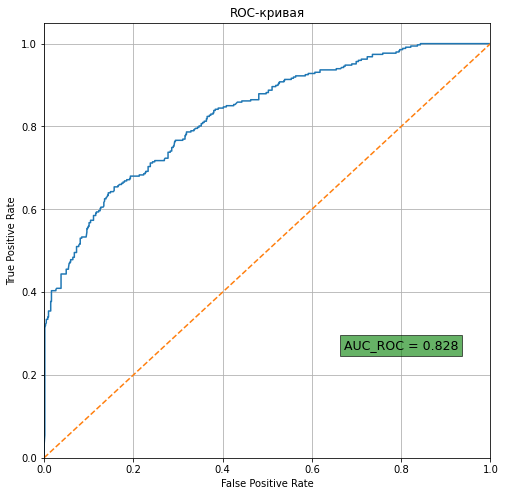

,predicted 0,predicted 1
actual 0,569,36
actual 1,182,165


In [41]:
probabilities_one_test = probabilities_test[:, 1]
predict_test = probabilities_one_test>0.5
#roc-кривая
fpr, tpr, thresholds = roc_curve(valid_ip['TARGET'], probabilities_one_test)
auc_roc = roc_auc_score(valid_ip['TARGET'], probabilities_one_test)
graph(fpr,tpr,auc_roc)
# матрица ошибок
conf_matrix(valid_ip['TARGET'], predict_test)

In [42]:
importances = model_cat_ip.feature_importances_
df_importances = pd.DataFrame(index=x_train_ip.drop(['TARGET'], axis=1).columns, columns=['importance'], data=importances)

df_importances.sort_values(by='importance',ascending=False).head(50)

,importance
count_okved,56.577041
OKVED_CODE_2,6.904279
OKVED_CODE,5.007240
SEX_NAME,4.902732
OKATO_FED_REGIONCODE,4.493241
AGE,4.194336
count,3.814240
OKVED_CODE_1,3.090832
CITIZENSHIP_NAME,3.085641
PLAINTIFF_SUM_YEAR,1.344128


## ЮЛ

In [43]:
# заменим категорию средним значением

def worker(row):
  if row['WORKERSRANGE'] == '0 .. 5':
    return 3
  elif row['WORKERSRANGE'] == '6 .. 10':
    return 8
  elif row['WORKERSRANGE'] == '11 .. 15':
    return 13
  elif row['WORKERSRANGE'] == '16 .. 50':
    return 34
  elif row['WORKERSRANGE'] == '51 .. 100':
    return 75
  elif row['WORKERSRANGE'] == '101 .. 150':
    return 125
  elif row['WORKERSRANGE'] == '151 .. 200':
    return 175
  elif row['WORKERSRANGE'] == '201 .. 250':
    return 225
  elif row['WORKERSRANGE'] == '251 .. 500':
    return 375
  elif row['WORKERSRANGE'] == '501 .. 1000':
    return 750
  elif row['WORKERSRANGE'] == '1001 .. 5000':
    return 3000
  elif row['WORKERSRANGE'] == '5000 и более':
    return 6000
  else:
    return np.nan

x_train_yr['worker'] = x_train_yr.apply(worker, axis=1)
valid_yr['worker'] = valid_yr.apply(worker, axis=1)

train_yr['worker'] = train_yr.apply(worker, axis=1)
test_yr['worker'] = test_yr.apply(worker, axis=1)


x_train_yr = x_train_yr.drop(['WORKERSRANGE'], axis=1)
valid_yr = valid_yr.drop(['WORKERSRANGE'], axis=1)

train_yr = train_yr.drop(['WORKERSRANGE'], axis=1)
test_yr = test_yr.drop(['WORKERSRANGE'], axis=1)

cat_names_yr.remove('WORKERSRANGE')


In [44]:
# объединим окфс окогу и окпф
x_train_yr['OKFS_OKOGU_OKOPF'] = x_train_yr.OKFS_GROUP + '_' + x_train_yr.OKOGU_GROUP + '_' + x_train_yr.OKOPF_GROUP
valid_yr['OKFS_OKOGU_OKOPF'] = valid_yr.OKFS_GROUP + '_' + valid_yr.OKOGU_GROUP + '_' + valid_yr.OKOPF_GROUP

train_yr['OKFS_OKOGU_OKOPF'] = train_yr.OKFS_GROUP + '_' + train_yr.OKOGU_GROUP + '_' + train_yr.OKOPF_GROUP
test_yr['OKFS_OKOGU_OKOPF'] = test_yr.OKFS_GROUP + '_' + test_yr.OKOGU_GROUP + '_' + test_yr.OKOPF_GROUP

cat_names_yr.append('OKFS_OKOGU_OKOPF')

cat_names_yr.remove('OKFS_GROUP')
cat_names_yr.remove('OKOGU_GROUP')
cat_names_yr.remove('OKOPF_GROUP')

x_train_yr = x_train_yr.drop(['OKFS_GROUP','OKOGU_GROUP','OKOPF_GROUP'], axis=1)
valid_yr = valid_yr.drop(['OKFS_GROUP','OKOGU_GROUP','OKOPF_GROUP'], axis=1)

train_yr = train_yr.drop(['OKFS_GROUP','OKOGU_GROUP','OKOPF_GROUP'], axis=1)
test_yr = test_yr .drop(['OKFS_GROUP','OKOGU_GROUP','OKOPF_GROUP'], axis=1)

In [45]:
%%time
model_cat_yr = CatBoostClassifier(loss_function='Logloss',iterations=1000, 
                                      verbose=100,
                                      cat_features=cat_names_yr)

CPU times: user 111 µs, sys: 8 µs, total: 119 µs
Wall time: 127 µs


In [46]:
model_cat_yr.fit(x_train_yr.drop(['TARGET'], axis=1),x_train_yr['TARGET'],
                     eval_set=(valid_yr.drop(['TARGET'], axis=1), valid_yr['TARGET']))

Learning rate set to 0.056066
0:	learn: 0.6245758	test: 0.6645151	best: 0.6645151 (0)	total: 59.8ms	remaining: 59.7s
100:	learn: 0.1410517	test: 0.3887747	best: 0.3887747 (100)	total: 4.69s	remaining: 41.8s
200:	learn: 0.1158269	test: 0.3792173	best: 0.3792064 (197)	total: 9.16s	remaining: 36.4s
300:	learn: 0.0985335	test: 0.3753017	best: 0.3751559 (299)	total: 13.5s	remaining: 31.4s
400:	learn: 0.0842020	test: 0.3721208	best: 0.3715110 (374)	total: 17.9s	remaining: 26.7s
500:	learn: 0.0729714	test: 0.3705826	best: 0.3704593 (478)	total: 22.4s	remaining: 22.4s
600:	learn: 0.0646467	test: 0.3702211	best: 0.3702211 (600)	total: 26.9s	remaining: 17.9s
700:	learn: 0.0583494	test: 0.3707137	best: 0.3702211 (600)	total: 31.5s	remaining: 13.4s
800:	learn: 0.0532025	test: 0.3714469	best: 0.3702211 (600)	total: 36s	remaining: 8.93s
900:	learn: 0.0487117	test: 0.3717444	best: 0.3702211 (600)	total: 40.6s	remaining: 4.46s
999:	learn: 0.0448822	test: 0.3726115	best: 0.3702211 (600)	total: 45.1s	re

In [47]:
# предсказание вероятностей`

probabilities_test = model_cat_yr.predict_proba(valid_yr.drop(['TARGET'], axis=1))

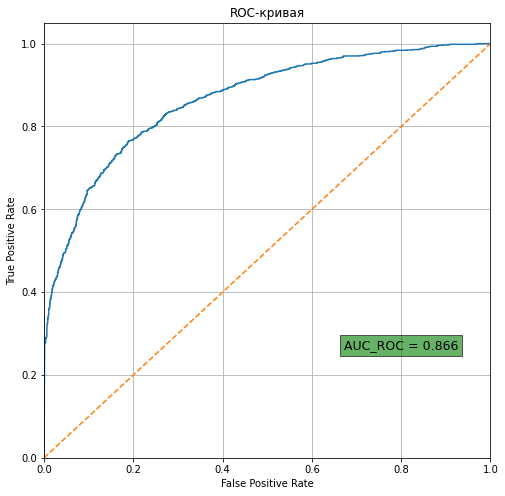

,predicted 0,predicted 1
actual 0,3444,301
actual 1,500,743


In [48]:
probabilities_one_test = probabilities_test[:, 1]
predict_test = probabilities_one_test>0.5
#roc-кривая
fpr, tpr, thresholds = roc_curve(valid_yr['TARGET'], probabilities_one_test)
auc_roc = roc_auc_score(valid_yr['TARGET'], probabilities_one_test)
graph(fpr,tpr,auc_roc)
# матрица ошибок
conf_matrix(valid_yr['TARGET'], predict_test)

In [49]:
importances = model_cat_yr.feature_importances_
df_importances = pd.DataFrame(index=x_train_yr.drop(['TARGET'], axis=1).columns, columns=['importance'], data=importances)

df_importances.sort_values(by='importance',ascending=False).head(50)

,importance
worker,11.824752
count_okved,11.427368
count,8.031611
OKVED_CODE,7.203158
OKATO_FED_REGIONCODE,4.214878
OKVED_CODE_1,3.759093
TELEPHONECOUNT,2.825769
SIGNEDNUMBER_95_EVER,2.033767
OKFS_OKOGU_OKOPF,2.019568
WINNERNUMBER_95_EVER,2.013602


In [50]:

stop

NameError: ignored

# Тестовая выборка

In [51]:
test_ip[cat_names_ip] = test_ip[cat_names_ip].astype(str)
test_yr[cat_names_yr] = test_yr[cat_names_yr].astype(str)


test_ip_1 = test_ip.drop(list_ip, axis=1)
test_yr_1 = test_yr.drop(list_yr, axis=1)


In [52]:
train_ip = train_ip.drop(list_ip, axis=1)
train_yr = train_yr.drop(list_yr, axis=1)

In [53]:
ip = round(300*1.2)
yr= round(700*1.2)

In [54]:
model_cat_ip = CatBoostClassifier(loss_function='Logloss',iterations=ip, 
                                  # depth=9,
                                  verbose=100, cat_features=cat_names_ip)

model_cat_yr = CatBoostClassifier(loss_function='Logloss',iterations=yr, 
                                  # depth=9,
                                  verbose=100, cat_features=cat_names_yr)


In [55]:
model_cat_ip.fit(train_ip.drop(['TARGET'], axis=1),train_ip['TARGET'])
model_cat_yr.fit(train_yr.drop(['TARGET'], axis=1),train_yr['TARGET'])


Learning rate set to 0.040988
0:	learn: 0.6512515	total: 8.67ms	remaining: 3.11s
100:	learn: 0.2289195	total: 917ms	remaining: 2.35s
200:	learn: 0.2059540	total: 1.77s	remaining: 1.4s
300:	learn: 0.1896471	total: 2.57s	remaining: 503ms
359:	learn: 0.1821560	total: 3.03s	remaining: 0us
Learning rate set to 0.038488
0:	learn: 0.6533466	total: 59.1ms	remaining: 49.6s
100:	learn: 0.2217882	total: 5.06s	remaining: 37s
200:	learn: 0.1983257	total: 9.98s	remaining: 31.7s
300:	learn: 0.1836938	total: 14.8s	remaining: 26.6s
400:	learn: 0.1704828	total: 19.6s	remaining: 21.5s
500:	learn: 0.1589957	total: 24.6s	remaining: 16.6s
600:	learn: 0.1489963	total: 29.4s	remaining: 11.7s
700:	learn: 0.1411881	total: 34.3s	remaining: 6.8s
800:	learn: 0.1334470	total: 39.3s	remaining: 1.91s
839:	learn: 0.1306054	total: 41.2s	remaining: 0us


In [56]:
probabilities_test_ip = model_cat_ip.predict_proba(test_ip_1)
probabilities_test_yr = model_cat_yr.predict_proba(test_yr_1)

In [57]:
test_ip['TARGET'] = probabilities_test_ip[:, 1]
test_yr['TARGET'] = probabilities_test_yr[:, 1]


In [58]:
data = pd.concat([test_ip, test_yr])
data = data.sort_index()

In [59]:
data[['id_contract', 'TARGET']].to_csv('125.csv', sep=';', index=False)
data[['id_contract', 'TARGET']].head(20)

,id_contract,TARGET
17891,17892,0.016807
17892,17893,0.007605
17893,17894,0.029634
17894,17895,0.217521
17895,17896,0.973291
17896,17897,0.035756
17897,17898,0.044403
17898,17899,0.988669
17899,17900,0.146368
17900,17901,0.260168
